<a href="https://colab.research.google.com/github/mamuncseru/100-Super-Notebooks/blob/main/EpilepsyDetectionCNNExperimentTensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# from google.colab import drive
# drive.mount('/content/drive')

## Import libraries

In [35]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import keras
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input, LSTM
from keras.layers import BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint


# from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf


In [36]:
## seed 
np.random.seed(2023)

## Reading CSV data

In [37]:
raw_data = pd.read_csv('https://raw.githubusercontent.com/mamuncseru/analysis_on_epileptic_seizure_bonn_dataset/main/Epileptic%20Seizure%20Recognition.csv')
raw_data.shape

(11500, 180)

In [38]:
raw_data

Unnamed   X1   X2   X3   X4   X5   X6   X7   X8   X9  ...  X170  \
0      X21.V1.791  135  190  229  223  192  125   55   -9  -33  ...   -17   
1      X15.V1.924  386  382  356  331  320  315  307  272  244  ...   164   
2         X8.V1.1  -32  -39  -47  -37  -32  -36  -57  -73  -85  ...    57   
3       X16.V1.60 -105 -101  -96  -92  -89  -95 -102 -100  -87  ...   -82   
4       X20.V1.54   -9  -65  -98 -102  -78  -48  -16    0  -21  ...     4   
...           ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   
11495  X22.V1.114  -22  -22  -23  -26  -36  -42  -45  -42  -45  ...    15   
11496  X19.V1.354  -47  -11   28   77  141  211  246  240  193  ...   -65   
11497    X8.V1.28   14    6  -13  -16   10   26   27   -9    4  ...   -65   
11498  X10.V1.932  -40  -25   -9  -12   -2   12    7   19   22  ...   121   
11499  X16.V1.210   29   41   57   72   74   62   54   43   31  ...   -59   

       X171  X172  X173  X174  X175  X176  X177  X178  y  
0       -15   -31   -77  -103  -127  -116   -83   -51  4  
1       150   146   152   157   156   154   143   129  1  
2        64    48    19   -12   -30   -35   -35   -36  5  
3       -81   -80   -77   -85   -77   -72   -69   -65  5  
4         2   -12   -32   -41   -65   -83   -89   -73  5  
...     ...   ...   ...   ...   ...   ...   ...   ... ..  
11495    16    12     5    -1   -18   -37   -47   -48  2  
11496   -33    -7    14    27    48    77   117   170  1  
11497   -48   -61   -62   -67   -30    -2    -1    -8  5  
11498   135   148   143   116    86    68    59    55  3  
11499   -25    -4     2     5     4    -2     2    20  4  

[11500 rows x 180 columns]

In [39]:
raw_data.values.shape

(11500, 180)

In [40]:
data = raw_data.values # converted to an numpy array
data = data[:, 1:] # discarding the Unnamed Column
data.shape

(11500, 179)

In [41]:
# let's see how it looks like
data

array([[135, 190, 229, ..., -83, -51, 4],
       [386, 382, 356, ..., 143, 129, 1],
       [-32, -39, -47, ..., -35, -36, 5],
       ...,
       [14, 6, -13, ..., -1, -8, 5],
       [-40, -25, -9, ..., 59, 55, 3],
       [29, 41, 57, ..., 2, 20, 4]], dtype=object)

In [42]:
# let's see the type 
type(data)

numpy.ndarray

## Classifying data categories as it mentioned in the paper

In [43]:
df_1 = data[data[:, -1] == 1].astype(int) # seizure
df_2 = data[data[:, -1] == 2].astype(int)
df_3 = data[data[:, -1] == 3].astype(int)
df_4 = data[data[:, -1] == 4].astype(int)
df_5 = data[data[:, -1] == 5].astype(int)

# let's print the shape of each category
print(df_1.shape)
print(df_2.shape)
print(df_3.shape)
print(df_4.shape)
print(df_5.shape)

(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)


## Let's plot some random data points from every category

In [44]:
def visualize_eeg(number_of_datapoints):
    for i in (np.random.randint(0, 2300, number_of_datapoints)):
        plt.plot(df_1[i, :], 'r-', label='df_1')
        plt.plot(df_2[i, :], 'g-', label='df_2')
        plt.plot(df_3[i, :], 'k-', label='df_3')
        plt.plot(df_4[i, :], 'b-', label='df_4')
        plt.plot(df_5[i, :], 'm-', label='df_5')
        plt.legend()
        plt.title(f'visualizing {i} th data point')
        plt.xlabel('time')
        plt.ylabel('aplitude(uV)')
        plt.show()

### Visualizing all categories in single figure

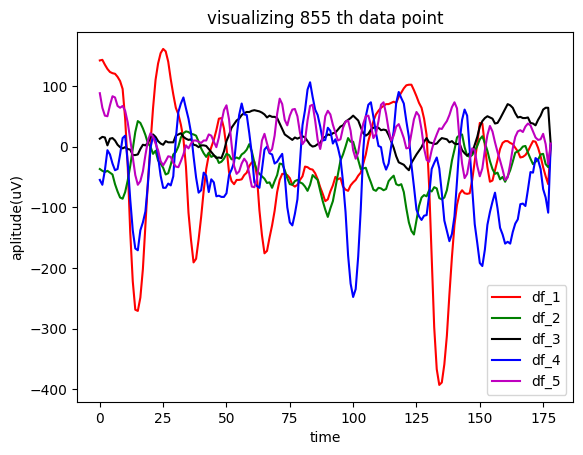

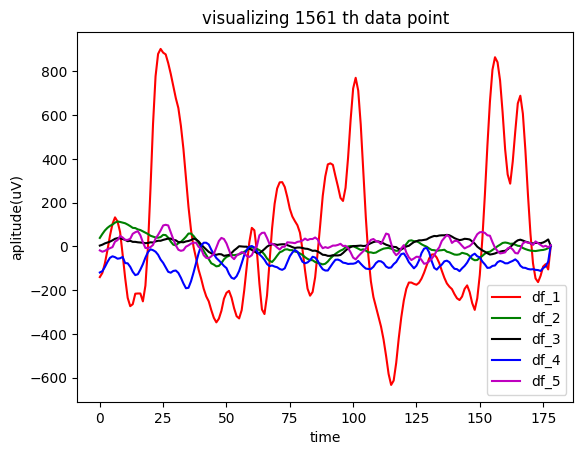

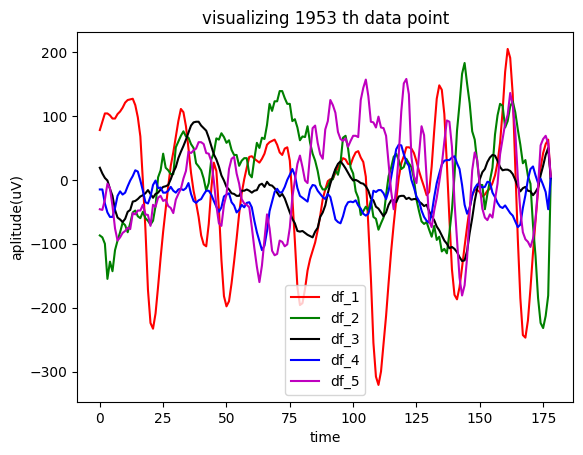

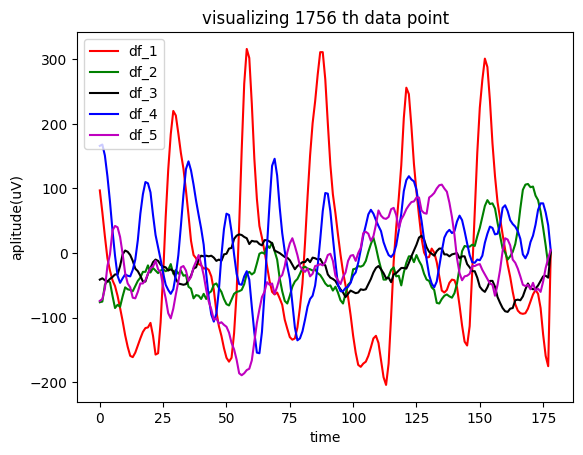

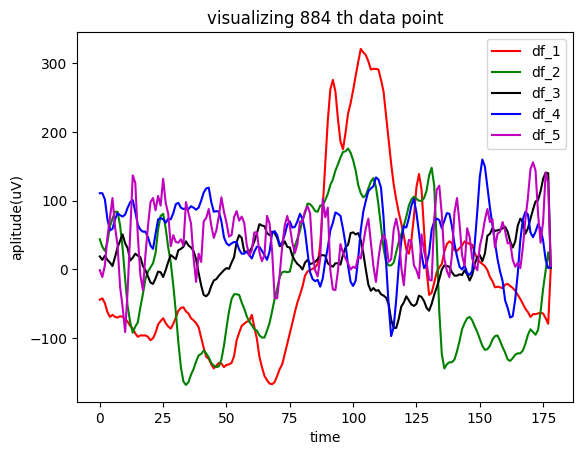

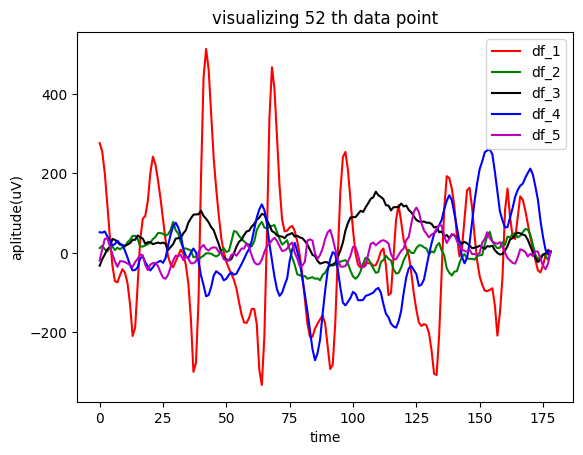

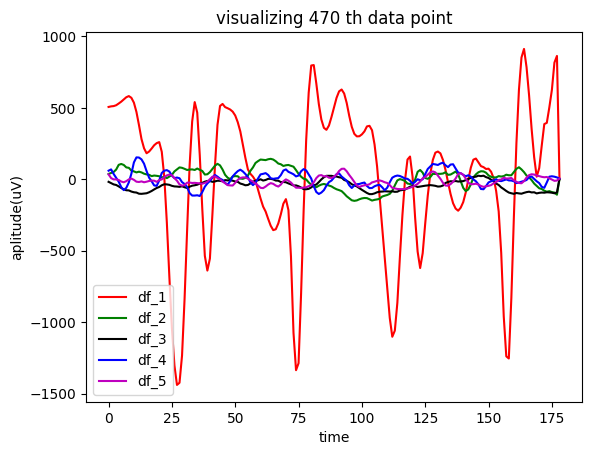

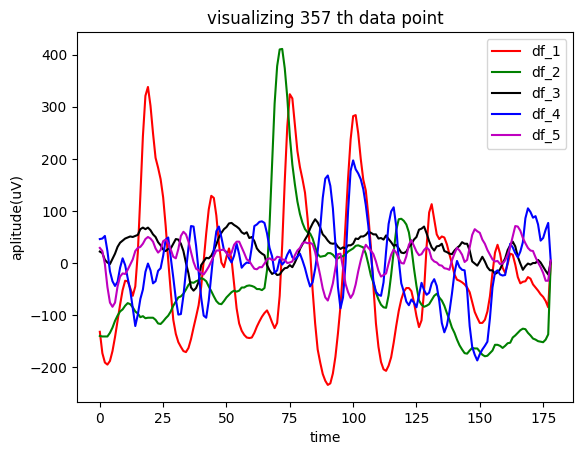

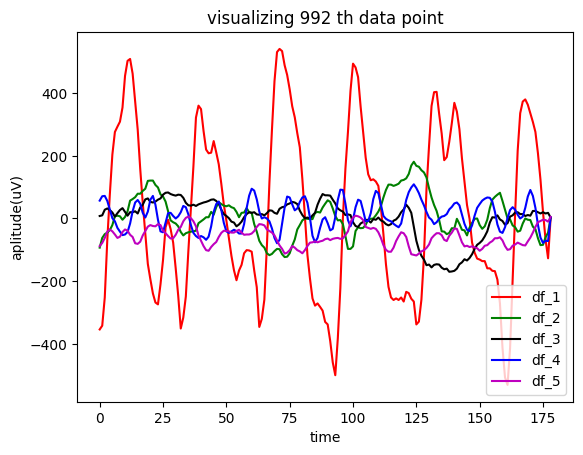

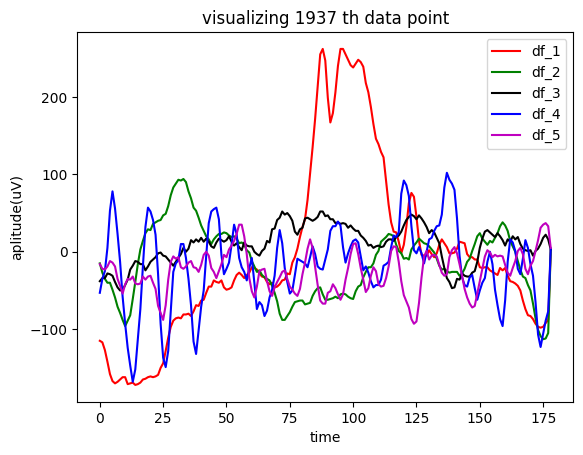

In [45]:
### all categories
visualize_eeg(10)

## Converting data into integer and making the data into seizure and non-seizure cateogry

In [46]:
all_data = data.copy().astype('int')

In [47]:
all_data

array([[135, 190, 229, ..., -83, -51,   4],
       [386, 382, 356, ..., 143, 129,   1],
       [-32, -39, -47, ..., -35, -36,   5],
       ...,
       [ 14,   6, -13, ...,  -1,  -8,   5],
       [-40, -25,  -9, ...,  59,  55,   3],
       [ 29,  41,  57, ...,   2,  20,   4]])

In [48]:
all_data[:, -1] = np.where(all_data[:, -1] != 1, 0, all_data[:, -1])
all_data

array([[135, 190, 229, ..., -83, -51,   0],
       [386, 382, 356, ..., 143, 129,   1],
       [-32, -39, -47, ..., -35, -36,   0],
       ...,
       [ 14,   6, -13, ...,  -1,  -8,   0],
       [-40, -25,  -9, ...,  59,  55,   0],
       [ 29,  41,  57, ...,   2,  20,   0]])

In [49]:
print(len(all_data[all_data[:, -1] == 1]))
print(len(all_data[all_data[:, -1] == 0]))

2300
9200


## Merge and Split dataset for training, validation and testing (80%:10%:10%)

In [50]:
def split_data(data, random_state=2023):
    
    X = all_data[:, :-1]
    y = all_data[:, -1]

    X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, stratify=y, test_size=.2, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, stratify=y_valtest, test_size=.5, random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test



In [51]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(all_data)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(9200, 178)
(1150, 178)
(1150, 178)
(9200,)
(1150,)
(1150,)


### let's expand the dimension to fit the data for CNN modelling

In [52]:
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(9200, 178, 1)
(1150, 178, 1)
(1150, 178, 1)


## Defining the CNN network architecture

## Model 1

without activation function and validation set it performs worst...

In [53]:
class eegClassifier(keras.Model):
    def __init__(self, input_shape):
        super(eegClassifier, self).__init__()

        # self.im_shape = (X_train.shape[1], 1)
        # self.inputs_cnn = Input(shape=(im_shape), name='inputs_cnn')
        
        self.conv1 = layers.Conv1D(filters=32, kernel_size=6, input_shape=input_shape)
        self.bn_1 = BatchNormalization()
        self.max_pool_1 = layers.MaxPooling1D(2, padding='same')

        self.conv2 = layers.Conv1D(filters=64, kernel_size=3)
        self.bn_2 = BatchNormalization()
        self.max_pool_2 = layers.MaxPooling1D(2, padding='same')

        
        self.flatten = Flatten()

        self.dense_1 = Dense(32)
        self.dense_2 = Dense(16)

        self.output_dense = Dense(2)

    def call(self, inputs):
        print('I am here entered...')
        x = self.conv1(inputs)
        print('printing the shape: ', x.shape)
        x = self.max_pool_1(self.bn_1(x))
        x = self.conv2(x)
        x = self.max_pool_2(self.bn_2(x))

        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.output_dense(x)

input_shape = (X_train.shape[1], 1)
model = eegClassifier(input_shape)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
X_train = X_train.astype('float32')
y_train = y_train.astype('int32')

In [54]:
history = model.fit(X_train, y_train, epochs=50)

Epoch 1/50
I am here entered...
printing the shape:  (None, 173, 32)
I am here entered...
printing the shape:  (None, 173, 32)
288/288 [==============================] - 5s 5ms/step - loss: 0.8448 - accuracy: 0.8045
Epoch 2/50
288/288 [==============================] - 2s 5ms/step - loss: 0.7180 - accuracy: 0.8528
Epoch 3/50
288/288 [==============================] - 2s 5ms/step - loss: 0.7076 - accuracy: 0.8610
Epoch 4/50
288/288 [==============================] - 2s 5ms/step - loss: 0.7044 - accuracy: 0.8611
Epoch 5/50
288/288 [==============================] - 2s 5ms/step - loss: 0.7092 - accuracy: 0.8605
Epoch 6/50
288/288 [==============================] - 2s 5ms/step - loss: 0.7076 - accuracy: 0.8587
Epoch 7/50
288/288 [==============================] - 2s 7ms/step - loss: 0.7266 - accuracy: 0.8297
Epoch 8/50
288/288 [==============================] - 2s 6ms/step - loss: 0.7045 - accuracy: 0.8040
Epoch 9/50
288/288 [==============================] - 2s 5ms/step - loss: 0.7463 - a

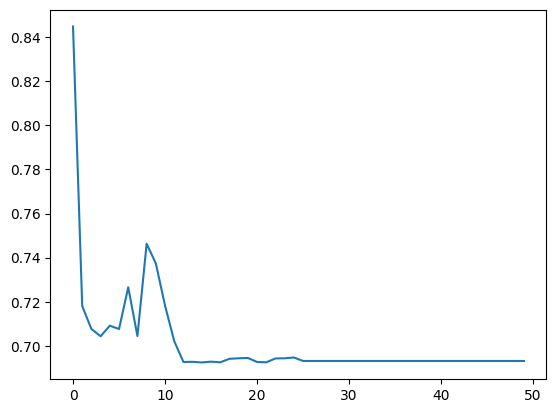

In [55]:
plt.plot(history.history['loss'])

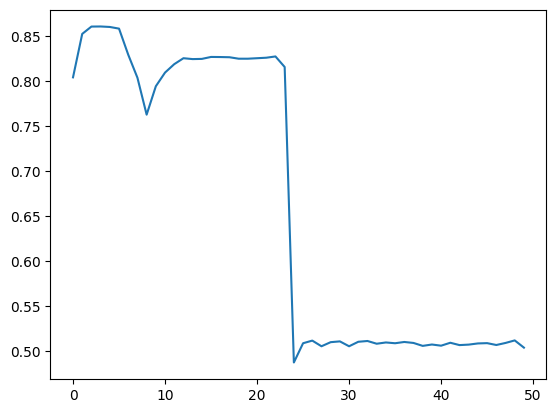

In [56]:
plt.plot(history.history['accuracy'])

## Model 2

In [57]:
class eegClassifier(keras.Model):
    def __init__(self, input_shape):
        super(eegClassifier, self).__init__()

        # self.im_shape = (X_train.shape[1], 1)
        # self.inputs_cnn = Input(shape=(im_shape), name='inputs_cnn')
        
        self.conv1 = layers.Conv1D(filters=32, kernel_size=6, input_shape=input_shape)
        self.bn_1 = BatchNormalization()
        self.max_pool_1 = layers.MaxPooling1D(2, padding='same')

        self.conv2 = layers.Conv1D(filters=64, kernel_size=3)
        self.bn_2 = BatchNormalization()
        self.max_pool_2 = layers.MaxPooling1D(2, padding='same')

        self.flatten = Flatten()

        self.dense_1 = Dense(32)
        self.dense_2 = Dense(16)

        self.output_dense = Dense(2, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = tf.nn.relu(self.bn_1(x))
        x = self.max_pool_1(x)

        x = self.conv2(x)
        x = tf.nn.relu(self.bn_2(x))
        x = self.max_pool_2(x)

        x = self.flatten(x)
        x = self.dense_1(x)
        x = tf.nn.relu(x)
        x = self.dense_2(x)
        x = tf.nn.relu(x)
        return self.output_dense(x)

input_shape = (X_train.shape[1], 1)
model = eegClassifier(input_shape)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

y_train = y_train.astype('int32')
y_val = y_val.astype('int32')

In [58]:
history2 = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
288/288 [==============================] - 6s 6ms/step - loss: 0.1484 - accuracy: 0.9413 - val_loss: 0.1231 - val_accuracy: 0.9600
Epoch 2/100
288/288 [==============================] - 2s 6ms/step - loss: 0.1108 - accuracy: 0.9548 - val_loss: 0.2029 - val_accuracy: 0.9348
Epoch 3/100
288/288 [==============================] - 2s 6ms/step - loss: 0.1041 - accuracy: 0.9614 - val_loss: 0.1014 - val_accuracy: 0.9591
Epoch 4/100
288/288 [==============================] - 2s 6ms/step - loss: 0.0800 - accuracy: 0.9672 - val_loss: 0.0888 - val_accuracy: 0.9678
Epoch 5/100
288/288 [==============================] - 2s 6ms/step - loss: 0.0799 - accuracy: 0.9695 - val_loss: 0.0891 - val_accuracy: 0.9617
Epoch 6/100
288/288 [==============================] - 2s 7ms/step - loss: 0.0678 - accuracy: 0.9746 - val_loss: 0.0792 - val_accuracy: 0.9704
Epoch 7/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0557 - accuracy: 0.9800 - val_loss: 0.0662 - val_accuracy: 0.9783

### function to plot loss curve of the training and validation loss


In [59]:
def plot_loss(history):
    plt.plot(history.history['loss'], 'b-')
    plt.plot(history.history['val_loss'], 'r-')
    plt.legend(['loss', 'val_loss'])
    plt.title('Loss curve')
    plt.xlabel('Epochs') 
    plt.ylabel('Loss %')
    plt.show()

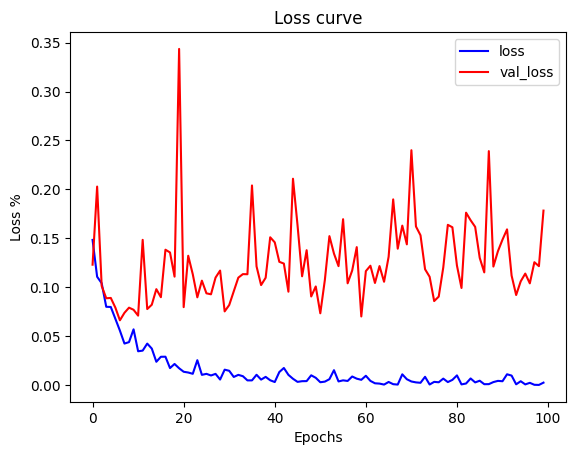

In [60]:
plot_loss(history2)

### function to plot accuracy curve of the training and validation accuracy


In [61]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], 'b-')
    plt.plot(history.history['val_accuracy'], 'r-')
    plt.legend(['accuracy', 'val_accuracy'])
    plt.title('Accuracy curve')
    plt.xlabel('Epochs') 
    plt.ylabel('accuracy %')
    plt.show()

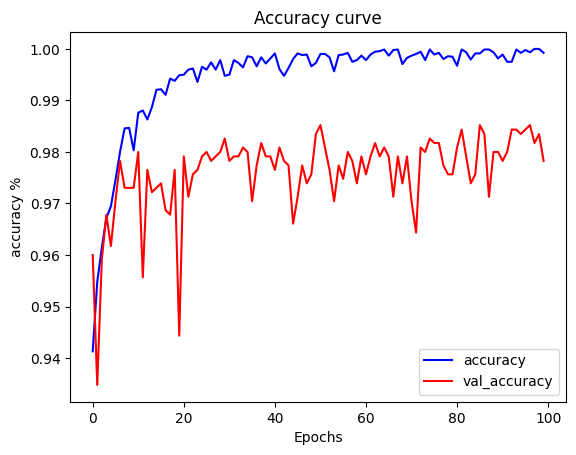

In [62]:
plot_accuracy(history2)

## Let's experiment with the number of units in conv1, conv2 layers

```
conv1 = [32, 64, 128, 256, 512]

conv2 = [64, 128, 256, 512, 1024]
```


### Experimental Model

In [63]:
class eegClassifier(keras.Model):
    def __init__(self, input_shape, c1_units, c2_units):
        super(eegClassifier, self).__init__()

        # self.im_shape = (X_train.shape[1], 1)
        # self.inputs_cnn = Input(shape=(im_shape), name='inputs_cnn')
        
        self.conv1 = layers.Conv1D(filters=c1_units, kernel_size=6, input_shape=input_shape)
        self.bn_1 = BatchNormalization()
        self.max_pool_1 = layers.MaxPooling1D(2, padding='same')

        self.conv2 = layers.Conv1D(filters=c2_units, kernel_size=3)
        self.bn_2 = BatchNormalization()
        self.max_pool_2 = layers.MaxPooling1D(2, padding='same')

        self.flatten = Flatten()

        self.dense_1 = Dense(32)
        self.dense_2 = Dense(16)

        self.output_dense = Dense(2, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = tf.nn.relu(self.bn_1(x))
        x = self.max_pool_1(x)

        x = self.conv2(x)
        x = tf.nn.relu(self.bn_2(x))
        x = self.max_pool_2(x)

        x = self.flatten(x)
        x = self.dense_1(x)
        x = tf.nn.relu(x)
        x = self.dense_2(x)
        x = tf.nn.relu(x)
        return self.output_dense(x)

input_shape = (X_train.shape[1], 1)

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

y_train = y_train.astype('int32')
y_val = y_val.astype('int32')





---- conv1 unit = 32 ---- conv2 unit = 64-------
Epoch 1/100
288/288 [==============================] - 4s 6ms/step - loss: 0.1487 - accuracy: 0.9412 - val_loss: 0.1094 - val_accuracy: 0.9574
Epoch 2/100
288/288 [==============================] - 2s 7ms/step - loss: 0.1031 - accuracy: 0.9591 - val_loss: 0.1155 - val_accuracy: 0.9583
Epoch 3/100
288/288 [==============================] - 2s 7ms/step - loss: 0.0870 - accuracy: 0.9666 - val_loss: 0.0889 - val_accuracy: 0.9609
Epoch 4/100
288/288 [==============================] - 2s 6ms/step - loss: 0.0756 - accuracy: 0.9718 - val_loss: 0.0700 - val_accuracy: 0.9783
Epoch 5/100
288/288 [==============================] - 2s 6ms/step - loss: 0.0622 - accuracy: 0.9785 - val_loss: 0.0765 - val_accuracy: 0.9730
Epoch 6/100
288/288 [==============================] - 2s 6ms/step - loss: 0.0654 - accuracy: 0.9758 - val_loss: 0.0919 - val_accuracy: 0.9678
Epoch 7/100
288/288 [==============================] - 2s 6ms/step - loss: 0.0557 - accur

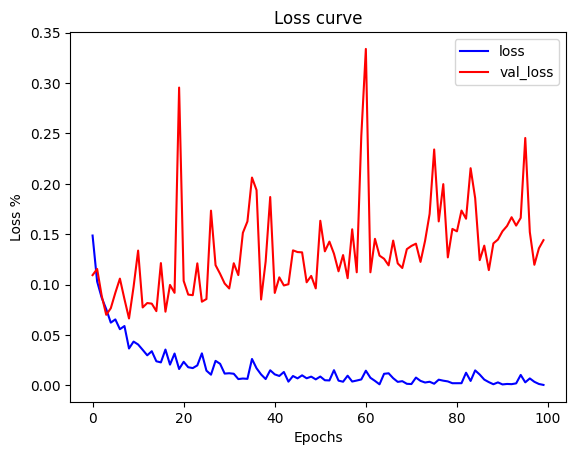

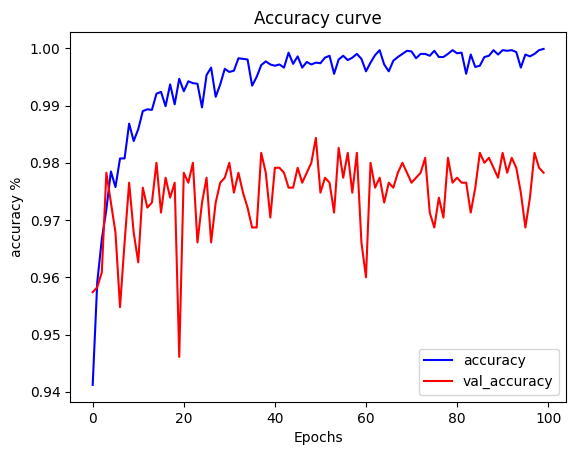





---- conv1 unit = 32 ---- conv2 unit = 128-------
Epoch 1/100
288/288 [==============================] - 5s 7ms/step - loss: 0.1423 - accuracy: 0.9445 - val_loss: 0.1003 - val_accuracy: 0.9565
Epoch 2/100
288/288 [==============================] - 2s 6ms/step - loss: 0.1077 - accuracy: 0.9598 - val_loss: 0.1572 - val_accuracy: 0.9478
Epoch 3/100
288/288 [==============================] - 2s 6ms/step - loss: 0.0862 - accuracy: 0.9664 - val_loss: 0.0704 - val_accuracy: 0.9730
Epoch 4/100
288/288 [==============================] - 2s 7ms/step - loss: 0.0673 - accuracy: 0.9739 - val_loss: 0.0709 - val_accuracy: 0.9783
Epoch 5/100
288/288 [==============================] - 3s 9ms/step - loss: 0.0743 - accuracy: 0.9736 - val_loss: 0.0759 - val_accuracy: 0.9730
Epoch 6/100
288/288 [==============================] - 2s 7ms/step - loss: 0.0553 - accuracy: 0.9813 - val_loss: 0.0664 - val_accuracy: 0.9809
Epoch 7/100
288/288 [==============================] - 2s 6ms/step - loss: 0.0485 - accu

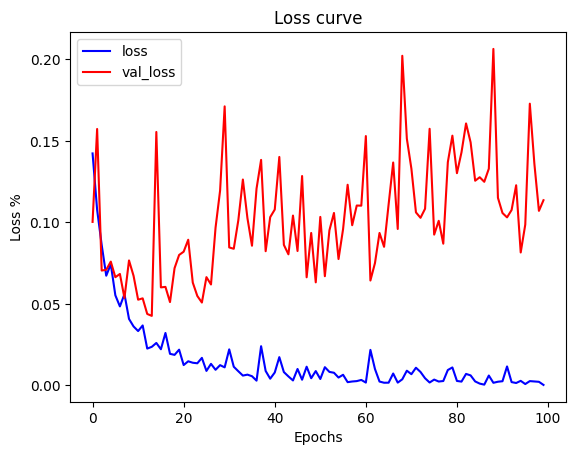

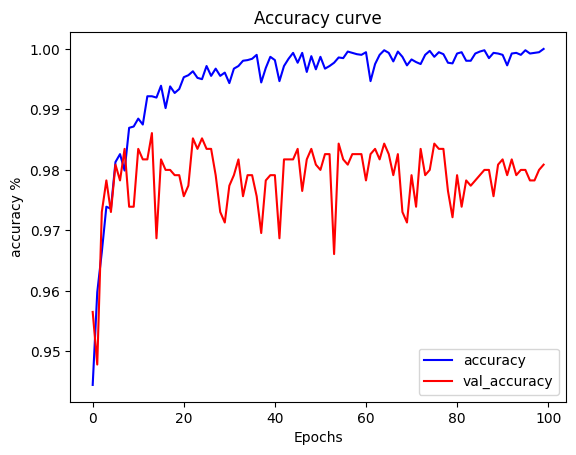





---- conv1 unit = 32 ---- conv2 unit = 256-------
Epoch 1/100
288/288 [==============================] - 5s 7ms/step - loss: 0.1598 - accuracy: 0.9418 - val_loss: 0.1007 - val_accuracy: 0.9522
Epoch 2/100
288/288 [==============================] - 2s 6ms/step - loss: 0.1179 - accuracy: 0.9574 - val_loss: 0.1282 - val_accuracy: 0.9426
Epoch 3/100
288/288 [==============================] - 2s 6ms/step - loss: 0.1057 - accuracy: 0.9613 - val_loss: 0.0946 - val_accuracy: 0.9652
Epoch 4/100
288/288 [==============================] - 2s 6ms/step - loss: 0.0857 - accuracy: 0.9679 - val_loss: 0.0912 - val_accuracy: 0.9661
Epoch 5/100
288/288 [==============================] - 2s 6ms/step - loss: 0.0697 - accuracy: 0.9740 - val_loss: 0.0786 - val_accuracy: 0.9678
Epoch 6/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0847 - accuracy: 0.9689 - val_loss: 0.0868 - val_accuracy: 0.9652
Epoch 7/100
288/288 [==============================] - 2s 6ms/step - loss: 0.0510 - accu

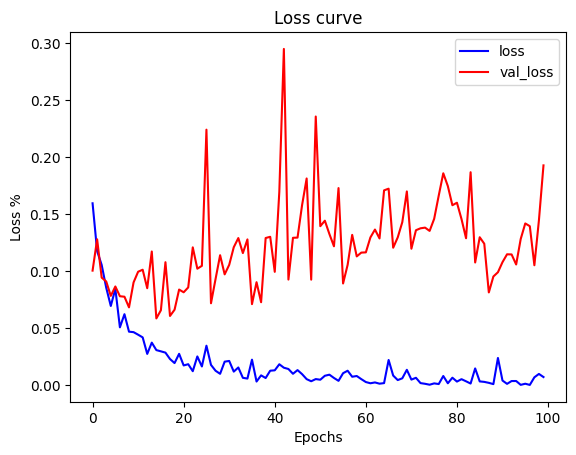

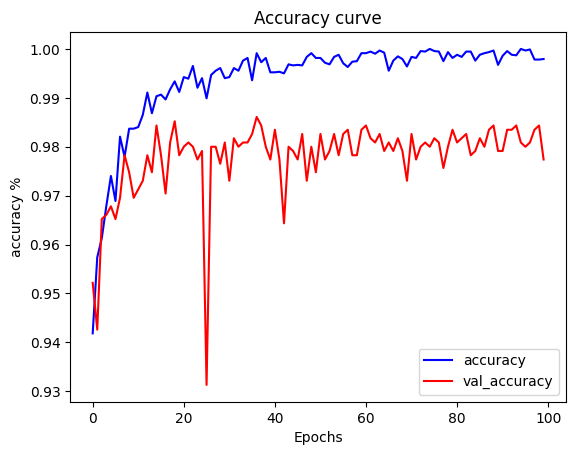





---- conv1 unit = 32 ---- conv2 unit = 512-------
Epoch 1/100
288/288 [==============================] - 5s 8ms/step - loss: 0.1603 - accuracy: 0.9383 - val_loss: 0.1422 - val_accuracy: 0.9609
Epoch 2/100
288/288 [==============================] - 2s 6ms/step - loss: 0.1224 - accuracy: 0.9526 - val_loss: 0.2211 - val_accuracy: 0.8739
Epoch 3/100
288/288 [==============================] - 2s 8ms/step - loss: 0.1146 - accuracy: 0.9560 - val_loss: 0.1062 - val_accuracy: 0.9539
Epoch 4/100
288/288 [==============================] - 2s 7ms/step - loss: 0.1019 - accuracy: 0.9602 - val_loss: 0.0895 - val_accuracy: 0.9635
Epoch 5/100
288/288 [==============================] - 2s 6ms/step - loss: 0.0880 - accuracy: 0.9658 - val_loss: 0.0845 - val_accuracy: 0.9652
Epoch 6/100
288/288 [==============================] - 2s 6ms/step - loss: 0.0764 - accuracy: 0.9687 - val_loss: 0.0928 - val_accuracy: 0.9687
Epoch 7/100
288/288 [==============================] - 2s 6ms/step - loss: 0.0790 - accu

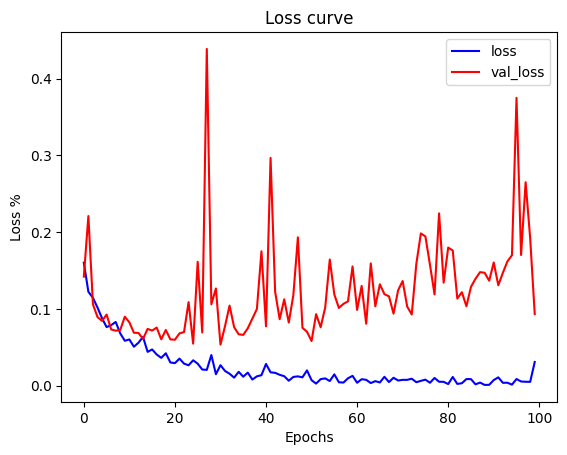

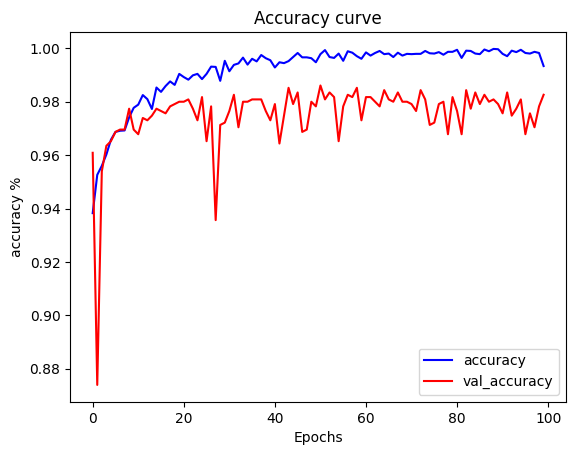





---- conv1 unit = 32 ---- conv2 unit = 1024-------
Epoch 1/100
288/288 [==============================] - 6s 11ms/step - loss: 0.3277 - accuracy: 0.9348 - val_loss: 0.1211 - val_accuracy: 0.9539
Epoch 2/100
288/288 [==============================] - 2s 8ms/step - loss: 0.1550 - accuracy: 0.9472 - val_loss: 0.2118 - val_accuracy: 0.9052
Epoch 3/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1185 - accuracy: 0.9570 - val_loss: 0.0946 - val_accuracy: 0.9704
Epoch 4/100
288/288 [==============================] - 2s 9ms/step - loss: 0.0908 - accuracy: 0.9671 - val_loss: 0.0926 - val_accuracy: 0.9687
Epoch 5/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0918 - accuracy: 0.9660 - val_loss: 0.0743 - val_accuracy: 0.9704
Epoch 6/100
288/288 [==============================] - 2s 9ms/step - loss: 0.0802 - accuracy: 0.9707 - val_loss: 0.0851 - val_accuracy: 0.9730
Epoch 7/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0673 - a

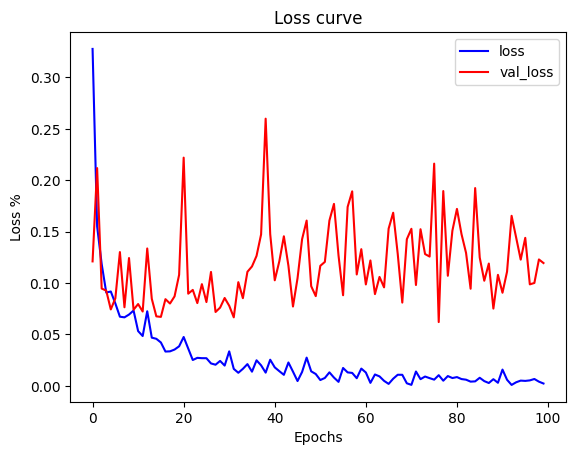

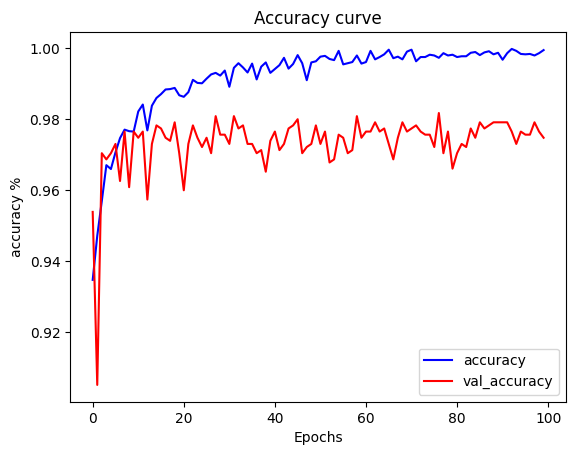





---- conv1 unit = 64 ---- conv2 unit = 64-------
Epoch 1/100
288/288 [==============================] - 6s 9ms/step - loss: 0.1322 - accuracy: 0.9517 - val_loss: 0.0947 - val_accuracy: 0.9643
Epoch 2/100
288/288 [==============================] - 2s 6ms/step - loss: 0.1032 - accuracy: 0.9616 - val_loss: 0.0877 - val_accuracy: 0.9670
Epoch 3/100
288/288 [==============================] - 2s 6ms/step - loss: 0.0849 - accuracy: 0.9664 - val_loss: 0.0951 - val_accuracy: 0.9661
Epoch 4/100
288/288 [==============================] - 2s 6ms/step - loss: 0.0755 - accuracy: 0.9704 - val_loss: 0.1179 - val_accuracy: 0.9600
Epoch 5/100
288/288 [==============================] - 2s 7ms/step - loss: 0.0706 - accuracy: 0.9745 - val_loss: 0.0960 - val_accuracy: 0.9591
Epoch 6/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0613 - accuracy: 0.9778 - val_loss: 0.0724 - val_accuracy: 0.9713
Epoch 7/100
288/288 [==============================] - 2s 6ms/step - loss: 0.0576 - accur

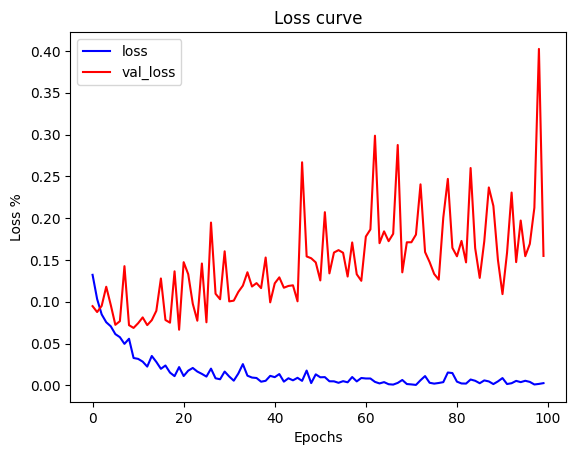

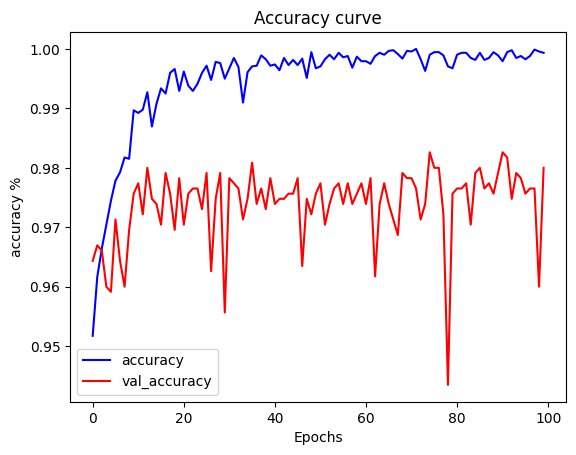





---- conv1 unit = 64 ---- conv2 unit = 128-------
Epoch 1/100
288/288 [==============================] - 6s 8ms/step - loss: 0.1443 - accuracy: 0.9405 - val_loss: 0.0998 - val_accuracy: 0.9670
Epoch 2/100
288/288 [==============================] - 2s 7ms/step - loss: 0.1196 - accuracy: 0.9547 - val_loss: 0.1180 - val_accuracy: 0.9513
Epoch 3/100
288/288 [==============================] - 2s 7ms/step - loss: 0.0985 - accuracy: 0.9624 - val_loss: 0.0923 - val_accuracy: 0.9713
Epoch 4/100
288/288 [==============================] - 2s 7ms/step - loss: 0.0915 - accuracy: 0.9664 - val_loss: 0.1098 - val_accuracy: 0.9661
Epoch 5/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0726 - accuracy: 0.9736 - val_loss: 0.0891 - val_accuracy: 0.9696
Epoch 6/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0637 - accuracy: 0.9755 - val_loss: 0.0957 - val_accuracy: 0.9678
Epoch 7/100
288/288 [==============================] - 2s 7ms/step - loss: 0.0689 - accu

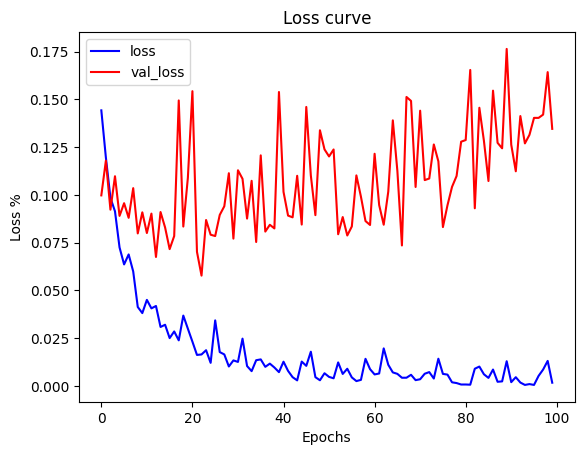

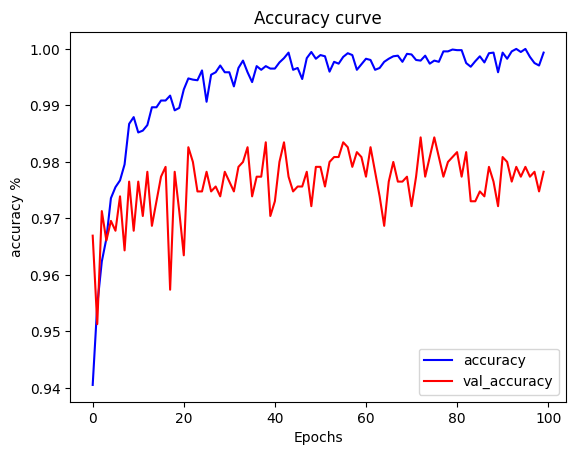





---- conv1 unit = 64 ---- conv2 unit = 256-------
Epoch 1/100
288/288 [==============================] - 5s 8ms/step - loss: 0.1671 - accuracy: 0.9395 - val_loss: 0.1182 - val_accuracy: 0.9565
Epoch 2/100
288/288 [==============================] - 2s 7ms/step - loss: 0.1274 - accuracy: 0.9512 - val_loss: 0.0994 - val_accuracy: 0.9591
Epoch 3/100
288/288 [==============================] - 2s 7ms/step - loss: 0.1047 - accuracy: 0.9608 - val_loss: 0.1386 - val_accuracy: 0.9487
Epoch 4/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0879 - accuracy: 0.9676 - val_loss: 0.1035 - val_accuracy: 0.9609
Epoch 5/100
288/288 [==============================] - 2s 7ms/step - loss: 0.0798 - accuracy: 0.9704 - val_loss: 0.1222 - val_accuracy: 0.9548
Epoch 6/100
288/288 [==============================] - 2s 7ms/step - loss: 0.0864 - accuracy: 0.9666 - val_loss: 0.1335 - val_accuracy: 0.9513
Epoch 7/100
288/288 [==============================] - 2s 7ms/step - loss: 0.0810 - accu

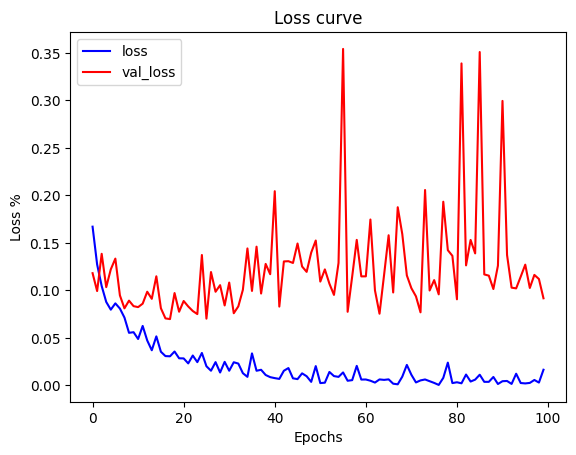

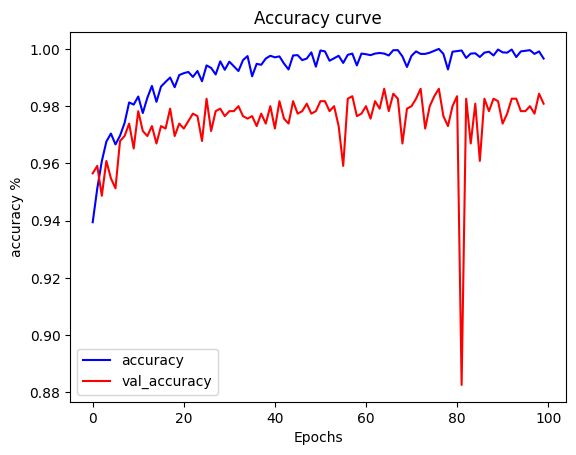





---- conv1 unit = 64 ---- conv2 unit = 512-------
Epoch 1/100
288/288 [==============================] - 6s 9ms/step - loss: 0.2014 - accuracy: 0.9322 - val_loss: 0.1212 - val_accuracy: 0.9417
Epoch 2/100
288/288 [==============================] - 2s 7ms/step - loss: 0.1301 - accuracy: 0.9487 - val_loss: 0.1255 - val_accuracy: 0.9504
Epoch 3/100
288/288 [==============================] - 2s 7ms/step - loss: 0.1138 - accuracy: 0.9537 - val_loss: 0.1211 - val_accuracy: 0.9600
Epoch 4/100
288/288 [==============================] - 2s 7ms/step - loss: 0.1181 - accuracy: 0.9532 - val_loss: 0.0979 - val_accuracy: 0.9565
Epoch 5/100
288/288 [==============================] - 2s 9ms/step - loss: 0.1039 - accuracy: 0.9607 - val_loss: 0.1399 - val_accuracy: 0.9470
Epoch 6/100
288/288 [==============================] - 2s 7ms/step - loss: 0.0962 - accuracy: 0.9610 - val_loss: 0.0884 - val_accuracy: 0.9678
Epoch 7/100
288/288 [==============================] - 2s 7ms/step - loss: 0.0960 - accu

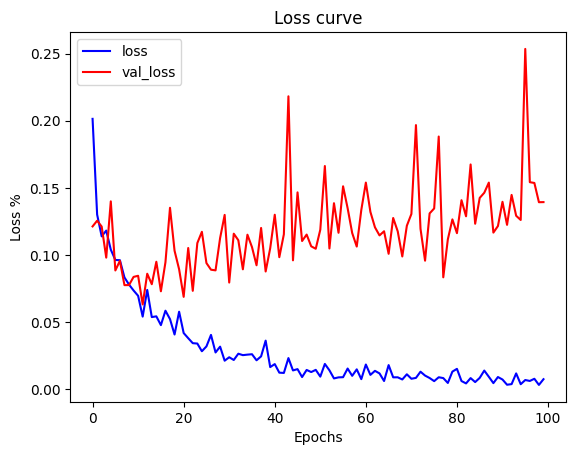

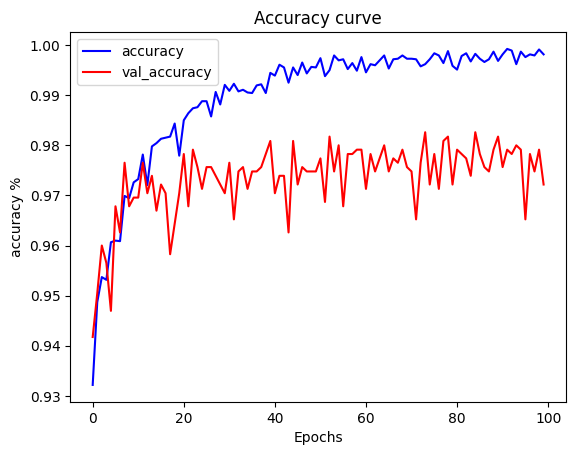





---- conv1 unit = 64 ---- conv2 unit = 1024-------
Epoch 1/100
288/288 [==============================] - 6s 12ms/step - loss: 0.2494 - accuracy: 0.9343 - val_loss: 0.1562 - val_accuracy: 0.9383
Epoch 2/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1449 - accuracy: 0.9491 - val_loss: 0.1490 - val_accuracy: 0.9487
Epoch 3/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1152 - accuracy: 0.9585 - val_loss: 0.1189 - val_accuracy: 0.9600
Epoch 4/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1076 - accuracy: 0.9598 - val_loss: 0.0910 - val_accuracy: 0.9678
Epoch 5/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1153 - accuracy: 0.9578 - val_loss: 0.1007 - val_accuracy: 0.9652
Epoch 6/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0932 - accuracy: 0.9652 - val_loss: 0.0847 - val_accuracy: 0.9713
Epoch 7/100
288/288 [==============================] - 3s 9ms/step - loss: 0.0806 - 

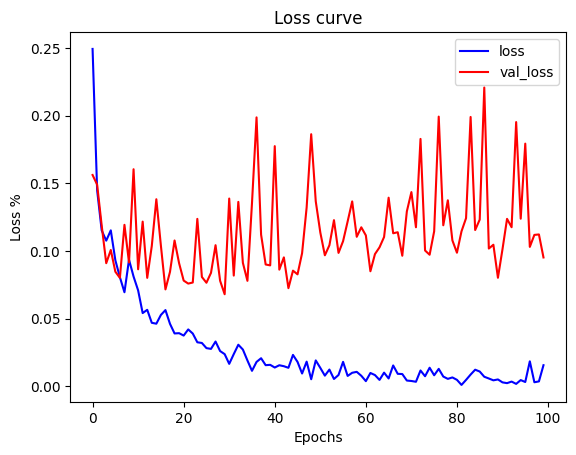

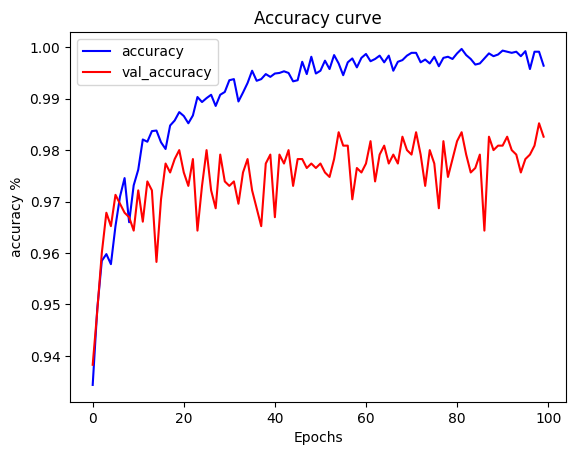





---- conv1 unit = 128 ---- conv2 unit = 64-------
Epoch 1/100
288/288 [==============================] - 6s 11ms/step - loss: 0.1420 - accuracy: 0.9457 - val_loss: 0.1193 - val_accuracy: 0.9548
Epoch 2/100
288/288 [==============================] - 2s 7ms/step - loss: 0.1051 - accuracy: 0.9585 - val_loss: 0.0861 - val_accuracy: 0.9652
Epoch 3/100
288/288 [==============================] - 2s 7ms/step - loss: 0.0937 - accuracy: 0.9666 - val_loss: 0.0819 - val_accuracy: 0.9713
Epoch 4/100
288/288 [==============================] - 2s 7ms/step - loss: 0.0878 - accuracy: 0.9659 - val_loss: 0.0768 - val_accuracy: 0.9722
Epoch 5/100
288/288 [==============================] - 2s 7ms/step - loss: 0.0700 - accuracy: 0.9724 - val_loss: 0.0826 - val_accuracy: 0.9687
Epoch 6/100
288/288 [==============================] - 2s 7ms/step - loss: 0.0646 - accuracy: 0.9733 - val_loss: 0.0740 - val_accuracy: 0.9748
Epoch 7/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0651 - acc

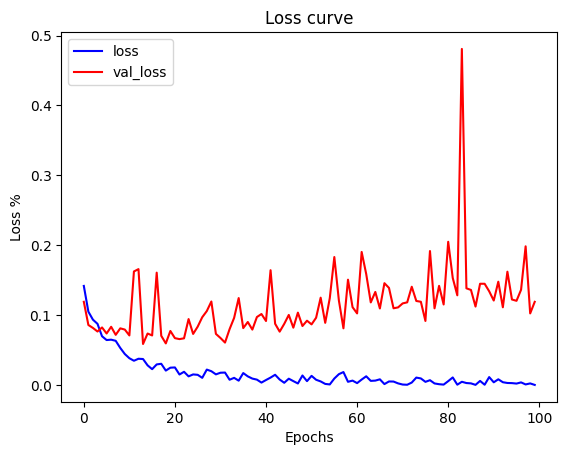

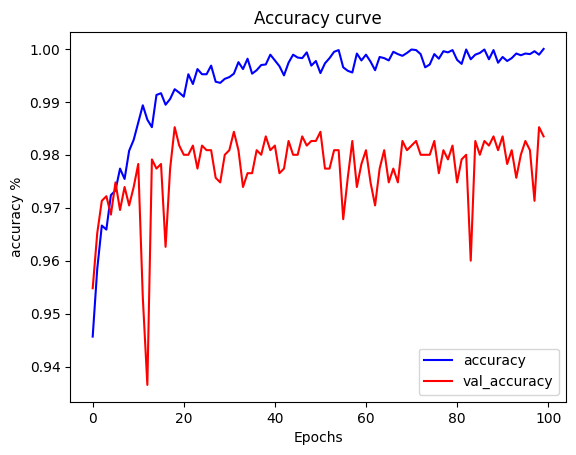





---- conv1 unit = 128 ---- conv2 unit = 128-------
Epoch 1/100
288/288 [==============================] - 6s 8ms/step - loss: 0.1449 - accuracy: 0.9438 - val_loss: 0.0962 - val_accuracy: 0.9626
Epoch 2/100
288/288 [==============================] - 2s 7ms/step - loss: 0.1109 - accuracy: 0.9551 - val_loss: 0.1046 - val_accuracy: 0.9565
Epoch 3/100
288/288 [==============================] - 2s 7ms/step - loss: 0.0851 - accuracy: 0.9683 - val_loss: 0.0979 - val_accuracy: 0.9565
Epoch 4/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0921 - accuracy: 0.9663 - val_loss: 0.1432 - val_accuracy: 0.9478
Epoch 5/100
288/288 [==============================] - 3s 9ms/step - loss: 0.0656 - accuracy: 0.9748 - val_loss: 0.0664 - val_accuracy: 0.9739
Epoch 6/100
288/288 [==============================] - 2s 7ms/step - loss: 0.0579 - accuracy: 0.9780 - val_loss: 0.0791 - val_accuracy: 0.9678
Epoch 7/100
288/288 [==============================] - 2s 7ms/step - loss: 0.0620 - acc

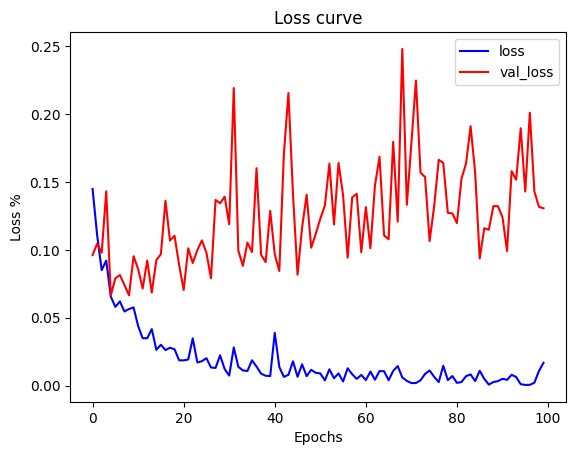

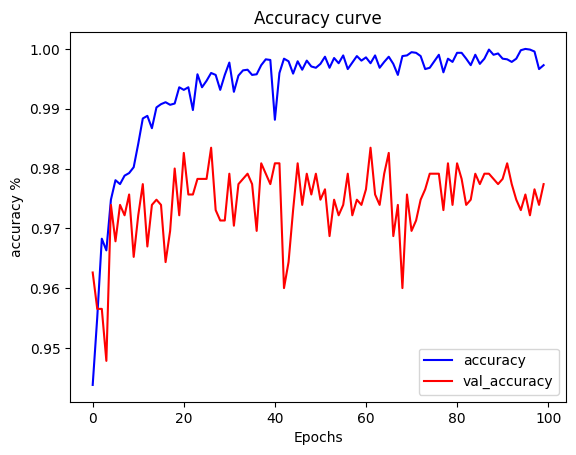





---- conv1 unit = 128 ---- conv2 unit = 256-------
Epoch 1/100
288/288 [==============================] - 6s 9ms/step - loss: 0.1494 - accuracy: 0.9424 - val_loss: 0.1336 - val_accuracy: 0.9557
Epoch 2/100
288/288 [==============================] - 2s 7ms/step - loss: 0.1233 - accuracy: 0.9524 - val_loss: 0.0896 - val_accuracy: 0.9652
Epoch 3/100
288/288 [==============================] - 2s 8ms/step - loss: 0.1130 - accuracy: 0.9545 - val_loss: 0.0925 - val_accuracy: 0.9652
Epoch 4/100
288/288 [==============================] - 2s 9ms/step - loss: 0.0908 - accuracy: 0.9663 - val_loss: 0.0815 - val_accuracy: 0.9678
Epoch 5/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0932 - accuracy: 0.9652 - val_loss: 0.0824 - val_accuracy: 0.9687
Epoch 6/100
288/288 [==============================] - 2s 7ms/step - loss: 0.0739 - accuracy: 0.9716 - val_loss: 0.0724 - val_accuracy: 0.9757
Epoch 7/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0720 - acc

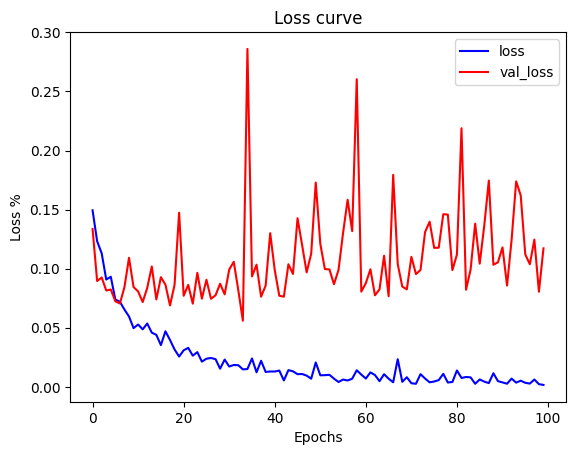

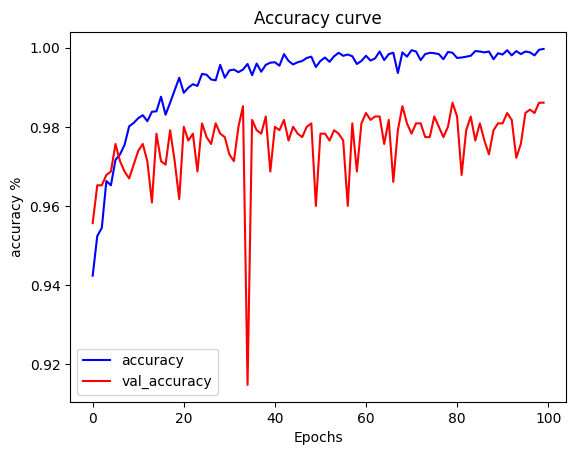





---- conv1 unit = 128 ---- conv2 unit = 512-------
Epoch 1/100
288/288 [==============================] - 6s 11ms/step - loss: 0.1665 - accuracy: 0.9399 - val_loss: 0.1042 - val_accuracy: 0.9600
Epoch 2/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1299 - accuracy: 0.9478 - val_loss: 0.1396 - val_accuracy: 0.9304
Epoch 3/100
288/288 [==============================] - 2s 8ms/step - loss: 0.1125 - accuracy: 0.9575 - val_loss: 0.1031 - val_accuracy: 0.9600
Epoch 4/100
288/288 [==============================] - 2s 8ms/step - loss: 0.1044 - accuracy: 0.9583 - val_loss: 0.1333 - val_accuracy: 0.9400
Epoch 5/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0906 - accuracy: 0.9660 - val_loss: 0.0781 - val_accuracy: 0.9678
Epoch 6/100
288/288 [==============================] - 2s 9ms/step - loss: 0.0768 - accuracy: 0.9704 - val_loss: 0.0970 - val_accuracy: 0.9643
Epoch 7/100
288/288 [==============================] - 3s 9ms/step - loss: 0.0725 - ac

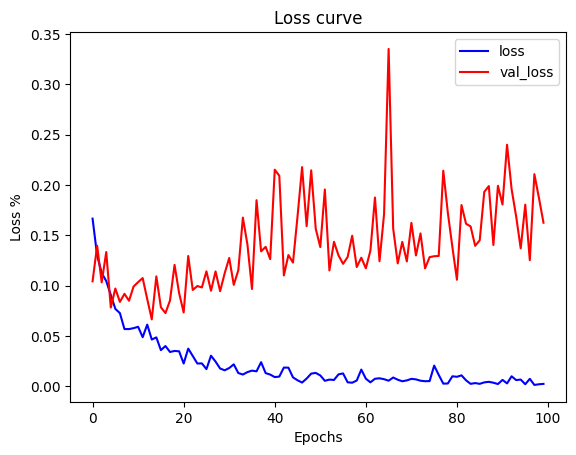

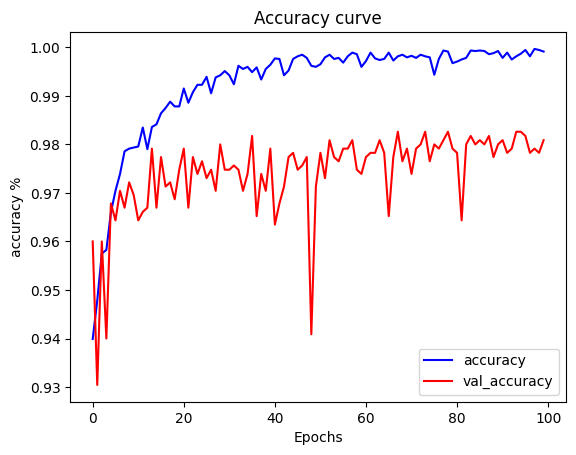





---- conv1 unit = 128 ---- conv2 unit = 1024-------
Epoch 1/100
288/288 [==============================] - 6s 12ms/step - loss: 0.3078 - accuracy: 0.9357 - val_loss: 0.1222 - val_accuracy: 0.9487
Epoch 2/100
288/288 [==============================] - 3s 12ms/step - loss: 0.1532 - accuracy: 0.9436 - val_loss: 0.1528 - val_accuracy: 0.9522
Epoch 3/100
288/288 [==============================] - 3s 11ms/step - loss: 0.1312 - accuracy: 0.9540 - val_loss: 0.1112 - val_accuracy: 0.9591
Epoch 4/100
288/288 [==============================] - 3s 11ms/step - loss: 0.1163 - accuracy: 0.9561 - val_loss: 0.1296 - val_accuracy: 0.9496
Epoch 5/100
288/288 [==============================] - 3s 11ms/step - loss: 0.1121 - accuracy: 0.9554 - val_loss: 0.1007 - val_accuracy: 0.9635
Epoch 6/100
288/288 [==============================] - 4s 12ms/step - loss: 0.1060 - accuracy: 0.9624 - val_loss: 0.1400 - val_accuracy: 0.9417
Epoch 7/100
288/288 [==============================] - 3s 11ms/step - loss: 0.10

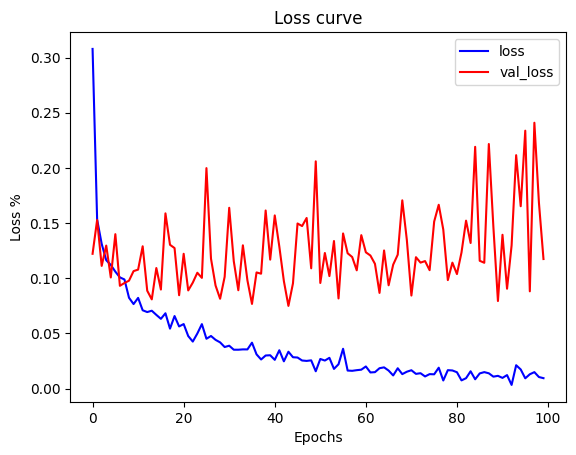

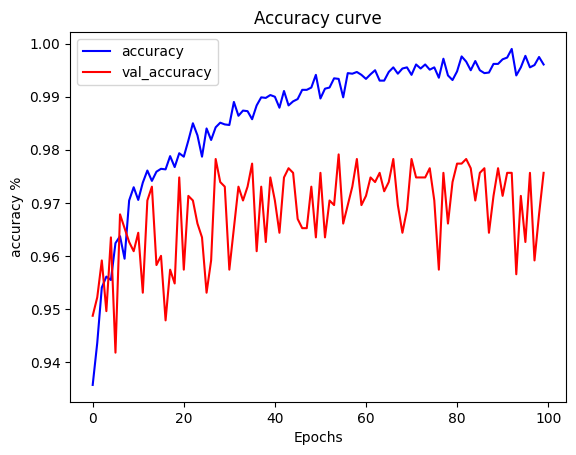





---- conv1 unit = 256 ---- conv2 unit = 64-------
Epoch 1/100
288/288 [==============================] - 6s 11ms/step - loss: 0.1402 - accuracy: 0.9450 - val_loss: 0.1331 - val_accuracy: 0.9522
Epoch 2/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1137 - accuracy: 0.9555 - val_loss: 0.1086 - val_accuracy: 0.9557
Epoch 3/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0922 - accuracy: 0.9655 - val_loss: 0.1025 - val_accuracy: 0.9643
Epoch 4/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0784 - accuracy: 0.9717 - val_loss: 0.0909 - val_accuracy: 0.9696
Epoch 5/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0762 - accuracy: 0.9710 - val_loss: 0.0872 - val_accuracy: 0.9713
Epoch 6/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0688 - accuracy: 0.9741 - val_loss: 0.0820 - val_accuracy: 0.9748
Epoch 7/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0660 - ac

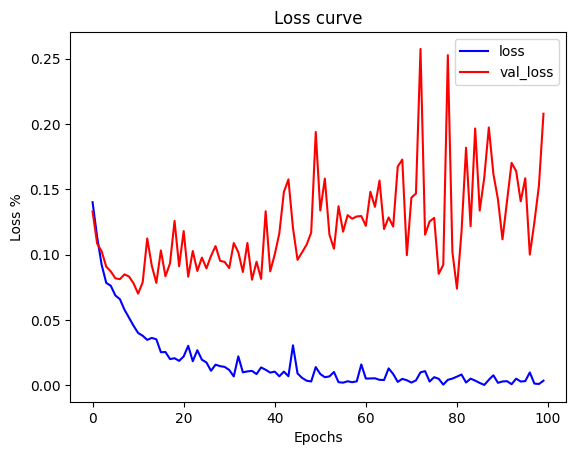

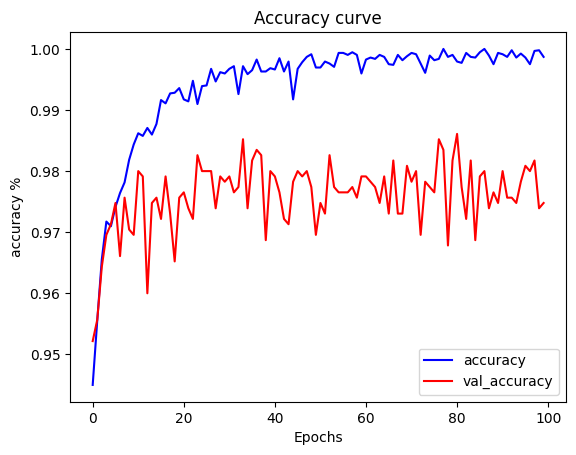





---- conv1 unit = 256 ---- conv2 unit = 128-------
Epoch 1/100
288/288 [==============================] - 7s 10ms/step - loss: 0.1576 - accuracy: 0.9412 - val_loss: 0.1247 - val_accuracy: 0.9574
Epoch 2/100
288/288 [==============================] - 2s 8ms/step - loss: 0.1077 - accuracy: 0.9607 - val_loss: 0.0975 - val_accuracy: 0.9600
Epoch 3/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0924 - accuracy: 0.9643 - val_loss: 0.0772 - val_accuracy: 0.9696
Epoch 4/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0816 - accuracy: 0.9727 - val_loss: 0.0911 - val_accuracy: 0.9591
Epoch 5/100
288/288 [==============================] - 3s 9ms/step - loss: 0.0680 - accuracy: 0.9751 - val_loss: 0.1254 - val_accuracy: 0.9548
Epoch 6/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0664 - accuracy: 0.9771 - val_loss: 0.0742 - val_accuracy: 0.9713
Epoch 7/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0639 - a

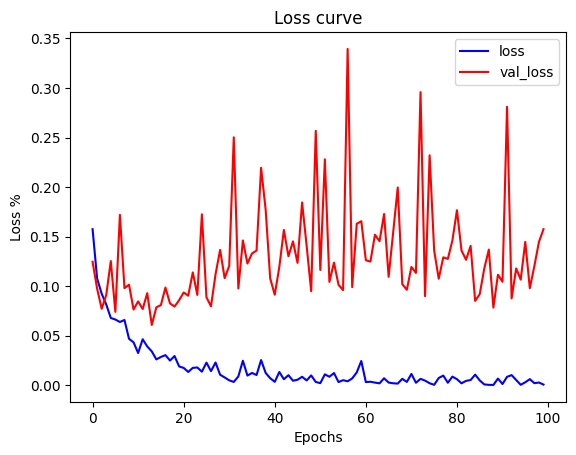

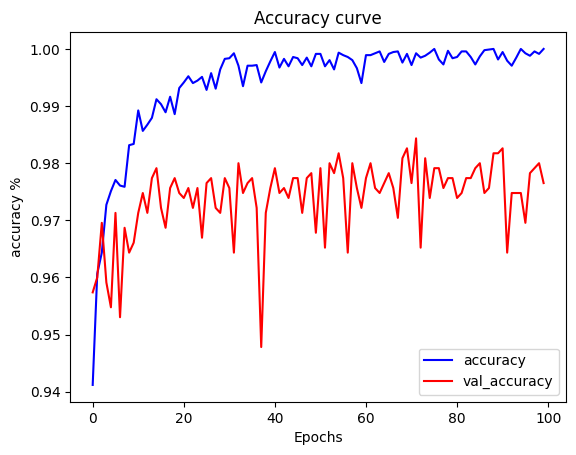





---- conv1 unit = 256 ---- conv2 unit = 256-------
Epoch 1/100
288/288 [==============================] - 6s 11ms/step - loss: 0.1655 - accuracy: 0.9374 - val_loss: 0.1256 - val_accuracy: 0.9548
Epoch 2/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1300 - accuracy: 0.9487 - val_loss: 0.1160 - val_accuracy: 0.9661
Epoch 3/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1115 - accuracy: 0.9563 - val_loss: 0.0904 - val_accuracy: 0.9670
Epoch 4/100
288/288 [==============================] - 2s 8ms/step - loss: 0.1062 - accuracy: 0.9593 - val_loss: 0.0875 - val_accuracy: 0.9617
Epoch 5/100
288/288 [==============================] - 2s 8ms/step - loss: 0.1043 - accuracy: 0.9610 - val_loss: 0.1482 - val_accuracy: 0.9504
Epoch 6/100
288/288 [==============================] - 3s 9ms/step - loss: 0.0823 - accuracy: 0.9739 - val_loss: 0.0762 - val_accuracy: 0.9757
Epoch 7/100
288/288 [==============================] - 3s 11ms/step - loss: 0.0708 - 

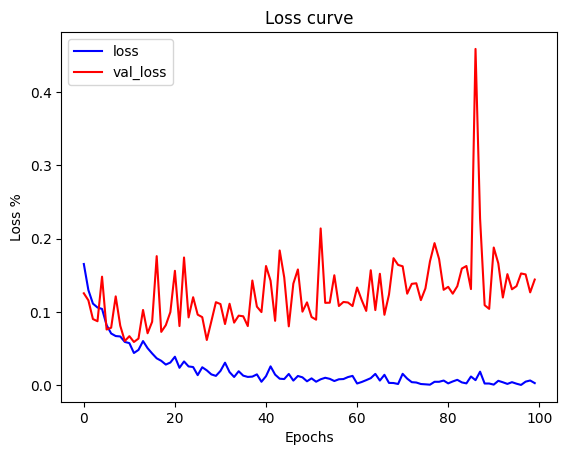

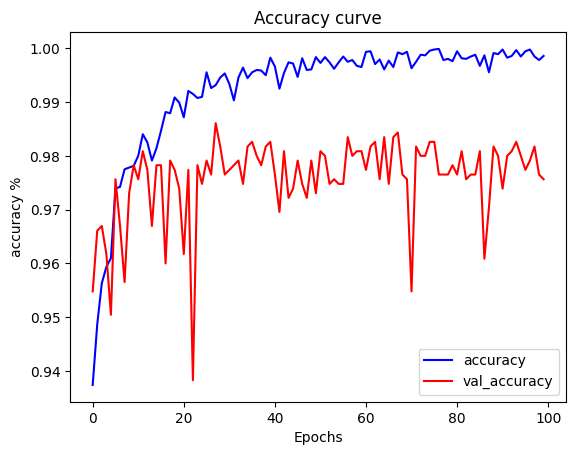





---- conv1 unit = 256 ---- conv2 unit = 512-------
Epoch 1/100
288/288 [==============================] - 7s 11ms/step - loss: 0.1703 - accuracy: 0.9396 - val_loss: 0.1098 - val_accuracy: 0.9565
Epoch 2/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1270 - accuracy: 0.9521 - val_loss: 0.1017 - val_accuracy: 0.9539
Epoch 3/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1173 - accuracy: 0.9565 - val_loss: 0.1063 - val_accuracy: 0.9626
Epoch 4/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1015 - accuracy: 0.9618 - val_loss: 0.0856 - val_accuracy: 0.9652
Epoch 5/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0857 - accuracy: 0.9685 - val_loss: 0.0824 - val_accuracy: 0.9670
Epoch 6/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0680 - accuracy: 0.9733 - val_loss: 0.0794 - val_accuracy: 0.9687
Epoch 7/100
288/288 [==============================] - 3s 10ms/step - loss: 0.071

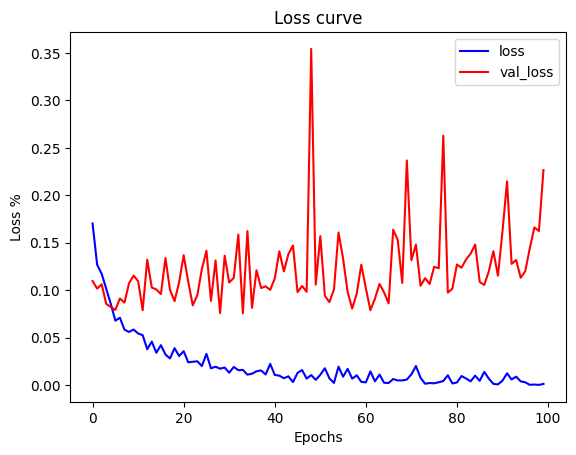

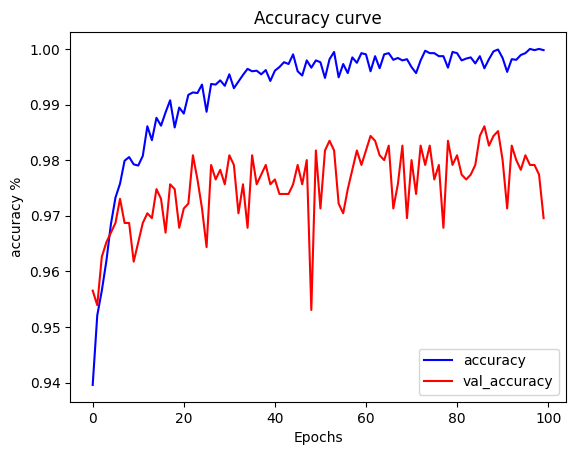





---- conv1 unit = 256 ---- conv2 unit = 1024-------
Epoch 1/100
288/288 [==============================] - 8s 16ms/step - loss: 0.4697 - accuracy: 0.9283 - val_loss: 0.1436 - val_accuracy: 0.9348
Epoch 2/100
288/288 [==============================] - 4s 14ms/step - loss: 0.1623 - accuracy: 0.9380 - val_loss: 0.1259 - val_accuracy: 0.9461
Epoch 3/100
288/288 [==============================] - 4s 13ms/step - loss: 0.1426 - accuracy: 0.9439 - val_loss: 0.1737 - val_accuracy: 0.9365
Epoch 4/100
288/288 [==============================] - 4s 13ms/step - loss: 0.1449 - accuracy: 0.9467 - val_loss: 0.1147 - val_accuracy: 0.9548
Epoch 5/100
288/288 [==============================] - 4s 15ms/step - loss: 0.1307 - accuracy: 0.9522 - val_loss: 0.0977 - val_accuracy: 0.9635
Epoch 6/100
288/288 [==============================] - 4s 13ms/step - loss: 0.1177 - accuracy: 0.9553 - val_loss: 0.0904 - val_accuracy: 0.9565
Epoch 7/100
288/288 [==============================] - 4s 14ms/step - loss: 0.11

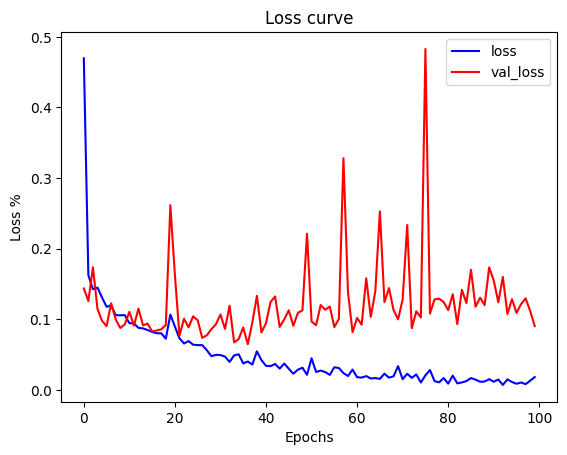

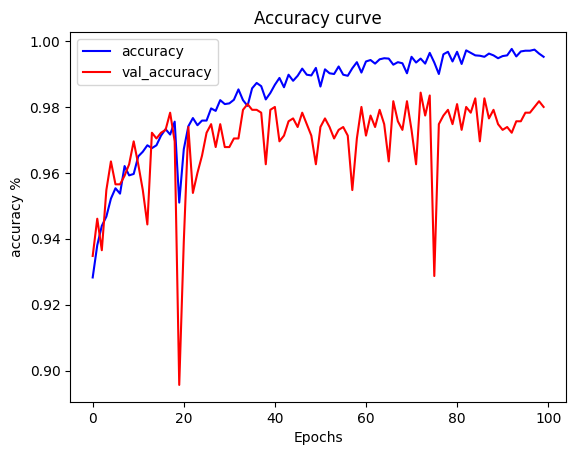





---- conv1 unit = 512 ---- conv2 unit = 64-------
Epoch 1/100
288/288 [==============================] - 7s 12ms/step - loss: 0.1521 - accuracy: 0.9404 - val_loss: 0.1093 - val_accuracy: 0.9513
Epoch 2/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1258 - accuracy: 0.9491 - val_loss: 0.1003 - val_accuracy: 0.9574
Epoch 3/100
288/288 [==============================] - 3s 11ms/step - loss: 0.1111 - accuracy: 0.9552 - val_loss: 0.0996 - val_accuracy: 0.9600
Epoch 4/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0923 - accuracy: 0.9638 - val_loss: 0.1481 - val_accuracy: 0.9426
Epoch 5/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0883 - accuracy: 0.9666 - val_loss: 0.0982 - val_accuracy: 0.9609
Epoch 6/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0671 - accuracy: 0.9748 - val_loss: 0.0900 - val_accuracy: 0.9678
Epoch 7/100
288/288 [==============================] - 3s 11ms/step - loss: 0.0660

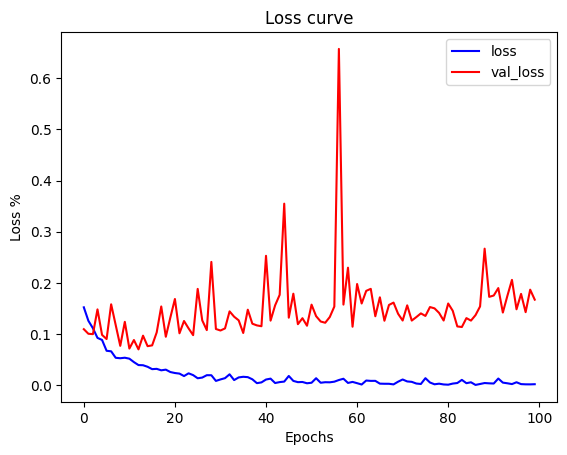

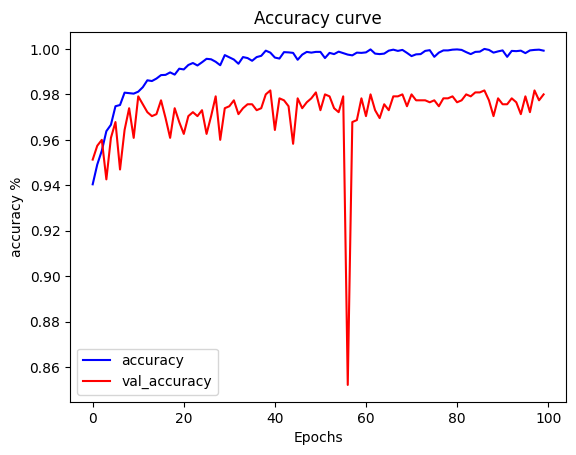





---- conv1 unit = 512 ---- conv2 unit = 128-------
Epoch 1/100
288/288 [==============================] - 7s 12ms/step - loss: 0.1420 - accuracy: 0.9472 - val_loss: 0.1231 - val_accuracy: 0.9557
Epoch 2/100
288/288 [==============================] - 3s 12ms/step - loss: 0.1139 - accuracy: 0.9571 - val_loss: 0.1030 - val_accuracy: 0.9670
Epoch 3/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0929 - accuracy: 0.9642 - val_loss: 0.1019 - val_accuracy: 0.9652
Epoch 4/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0893 - accuracy: 0.9673 - val_loss: 0.1033 - val_accuracy: 0.9591
Epoch 5/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0787 - accuracy: 0.9708 - val_loss: 0.0997 - val_accuracy: 0.9626
Epoch 6/100
288/288 [==============================] - 3s 12ms/step - loss: 0.0802 - accuracy: 0.9733 - val_loss: 0.0986 - val_accuracy: 0.9652
Epoch 7/100
288/288 [==============================] - 3s 11ms/step - loss: 0.068

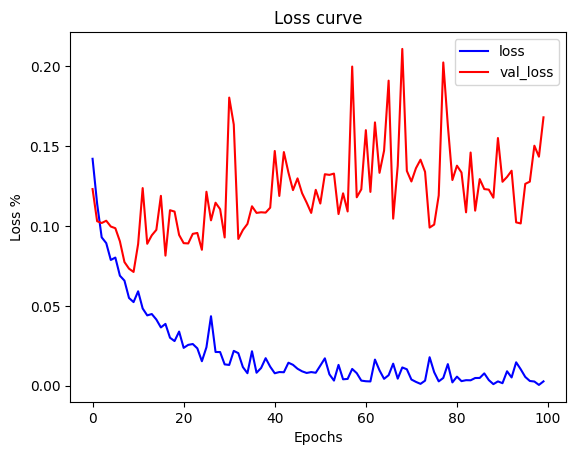

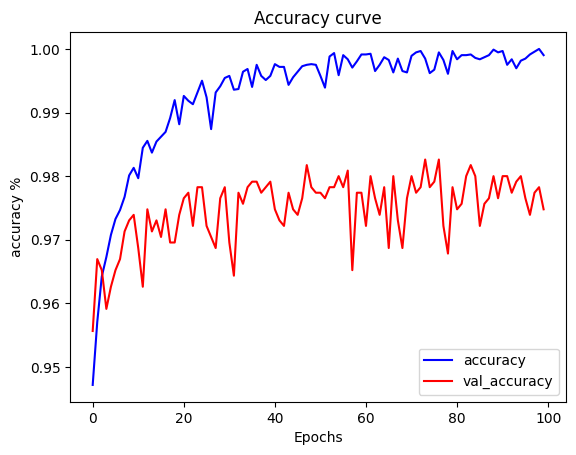





---- conv1 unit = 512 ---- conv2 unit = 256-------
Epoch 1/100
288/288 [==============================] - 7s 12ms/step - loss: 0.1653 - accuracy: 0.9427 - val_loss: 0.1339 - val_accuracy: 0.9513
Epoch 2/100
288/288 [==============================] - 3s 12ms/step - loss: 0.1230 - accuracy: 0.9518 - val_loss: 0.0977 - val_accuracy: 0.9530
Epoch 3/100
288/288 [==============================] - 3s 12ms/step - loss: 0.1124 - accuracy: 0.9565 - val_loss: 0.1283 - val_accuracy: 0.9443
Epoch 4/100
288/288 [==============================] - 3s 11ms/step - loss: 0.0960 - accuracy: 0.9627 - val_loss: 0.0980 - val_accuracy: 0.9574
Epoch 5/100
288/288 [==============================] - 3s 11ms/step - loss: 0.0960 - accuracy: 0.9646 - val_loss: 0.1660 - val_accuracy: 0.9374
Epoch 6/100
288/288 [==============================] - 3s 11ms/step - loss: 0.0846 - accuracy: 0.9679 - val_loss: 0.0924 - val_accuracy: 0.9678
Epoch 7/100
288/288 [==============================] - 4s 12ms/step - loss: 0.083

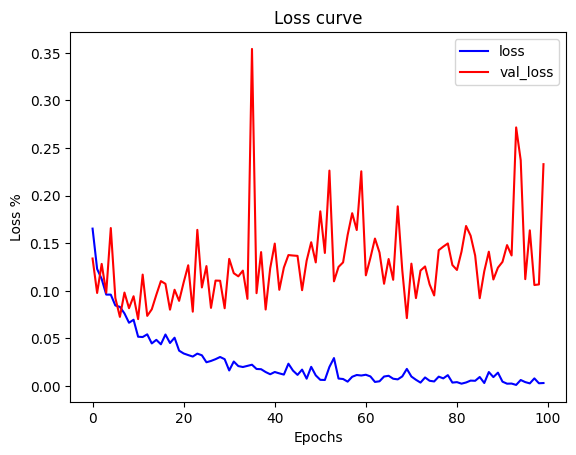

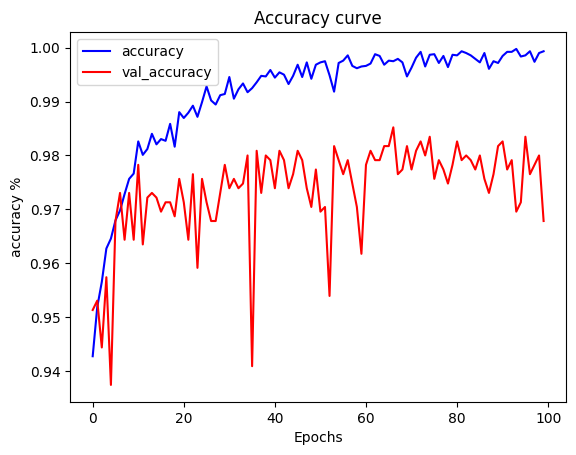





---- conv1 unit = 512 ---- conv2 unit = 512-------
Epoch 1/100
288/288 [==============================] - 7s 15ms/step - loss: 0.2654 - accuracy: 0.9345 - val_loss: 0.1157 - val_accuracy: 0.9609
Epoch 2/100
288/288 [==============================] - 4s 15ms/step - loss: 0.1263 - accuracy: 0.9511 - val_loss: 0.1362 - val_accuracy: 0.9530
Epoch 3/100
288/288 [==============================] - 4s 13ms/step - loss: 0.1298 - accuracy: 0.9502 - val_loss: 0.1032 - val_accuracy: 0.9643
Epoch 4/100
288/288 [==============================] - 4s 13ms/step - loss: 0.1156 - accuracy: 0.9565 - val_loss: 0.1106 - val_accuracy: 0.9591
Epoch 5/100
288/288 [==============================] - 4s 14ms/step - loss: 0.1117 - accuracy: 0.9582 - val_loss: 0.0888 - val_accuracy: 0.9678
Epoch 6/100
288/288 [==============================] - 4s 14ms/step - loss: 0.0956 - accuracy: 0.9629 - val_loss: 0.1188 - val_accuracy: 0.9435
Epoch 7/100
288/288 [==============================] - 4s 13ms/step - loss: 0.094

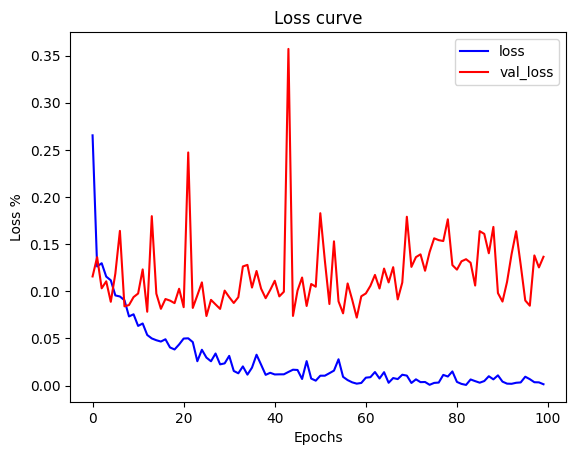

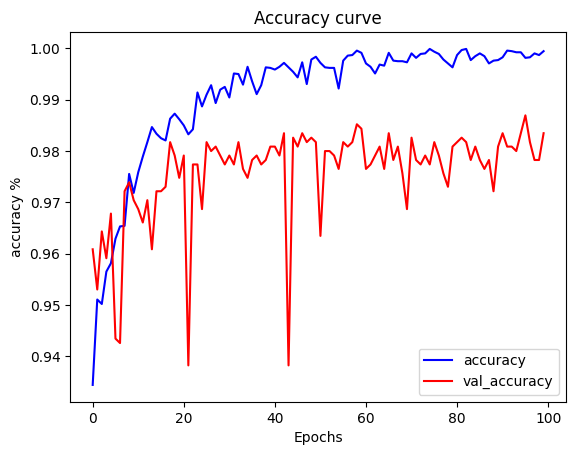





---- conv1 unit = 512 ---- conv2 unit = 1024-------
Epoch 1/100
288/288 [==============================] - 9s 20ms/step - loss: 0.2975 - accuracy: 0.9320 - val_loss: 0.1688 - val_accuracy: 0.9426
Epoch 2/100
288/288 [==============================] - 6s 20ms/step - loss: 0.1513 - accuracy: 0.9439 - val_loss: 0.1537 - val_accuracy: 0.9557
Epoch 3/100
288/288 [==============================] - 5s 18ms/step - loss: 0.1287 - accuracy: 0.9557 - val_loss: 0.1172 - val_accuracy: 0.9478
Epoch 4/100
288/288 [==============================] - 6s 20ms/step - loss: 0.1428 - accuracy: 0.9521 - val_loss: 0.1406 - val_accuracy: 0.9409
Epoch 5/100
288/288 [==============================] - 5s 19ms/step - loss: 0.1063 - accuracy: 0.9653 - val_loss: 0.0919 - val_accuracy: 0.9626
Epoch 6/100
288/288 [==============================] - 6s 19ms/step - loss: 0.0903 - accuracy: 0.9654 - val_loss: 0.1100 - val_accuracy: 0.9661
Epoch 7/100
288/288 [==============================] - 5s 19ms/step - loss: 0.09

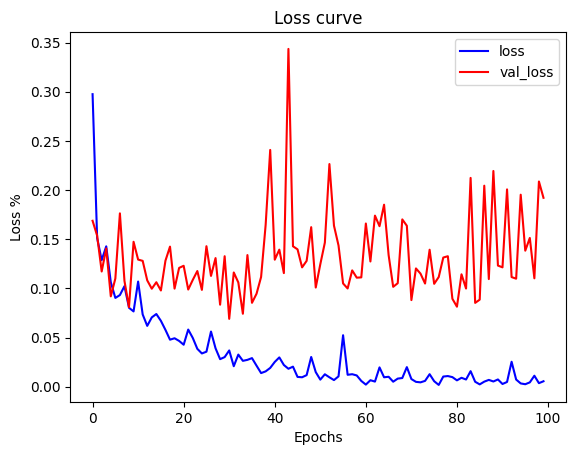

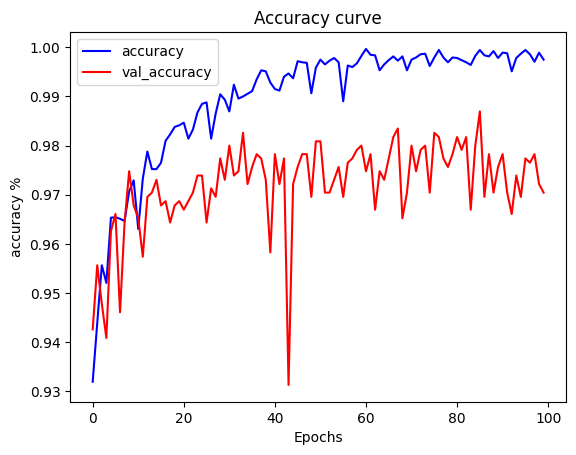

In [64]:
conv1 = [32, 64, 128, 256, 512]
conv2 = [64, 128, 256, 512, 1024]


all_history = []
all_models = []

for c1_units in conv1:
    for c2_units in conv2:
        model = eegClassifier(input_shape, c1_units, c2_units)
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        print('\n\n\n')
        print(f'---- conv1 unit = {c1_units} ---- conv2 unit = {c2_units}-------')
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)
        all_models.append(model)
        print('\n\n')
        print(model.summary())
        print('\n')
        plot_loss(history)
        plot_accuracy(history) 

        all_history.append(history)


## Let's experiment with the number of units in dense1, dense2 layers

```
dense1 = [32, 64, 128, 256, 512, 1024]

dense2 = [16, 32, 64, 128, 256, 512]
```


In [65]:
class eegClassifier(keras.Model):
    def __init__(self, input_shape, d1_units, d2_units):
        super(eegClassifier, self).__init__()
        
        self.conv1 = layers.Conv1D(filters=128, kernel_size=6, input_shape=input_shape)
        self.bn_1 = BatchNormalization()
        self.max_pool_1 = layers.MaxPooling1D(2, padding='same')

        self.conv2 = layers.Conv1D(filters=512, kernel_size=3)
        self.bn_2 = BatchNormalization()
        self.max_pool_2 = layers.MaxPooling1D(2, padding='same')

        self.flatten = Flatten()

        self.dense_1 = Dense(d1_units)
        self.dense_2 = Dense(d2_units)

        self.output_dense = Dense(2, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = tf.nn.relu(self.bn_1(x))
        x = self.max_pool_1(x)

        x = self.conv2(x)
        x = tf.nn.relu(self.bn_2(x))
        x = self.max_pool_2(x)

        x = self.flatten(x)
        x = self.dense_1(x)
        x = tf.nn.relu(x)
        x = self.dense_2(x)
        x = tf.nn.relu(x)
        return self.output_dense(x)






---- dense1 unit = 32 ---- dense2 unit = 16-------
Epoch 1/100
288/288 [==============================] - 5s 8ms/step - loss: 0.2504 - accuracy: 0.9312 - val_loss: 0.1374 - val_accuracy: 0.9504
Epoch 2/100
288/288 [==============================] - 2s 7ms/step - loss: 0.1564 - accuracy: 0.9484 - val_loss: 0.1089 - val_accuracy: 0.9565
Epoch 3/100
288/288 [==============================] - 2s 7ms/step - loss: 0.1157 - accuracy: 0.9576 - val_loss: 0.0900 - val_accuracy: 0.9652
Epoch 4/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0978 - accuracy: 0.9665 - val_loss: 0.1408 - val_accuracy: 0.9435
Epoch 5/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0929 - accuracy: 0.9696 - val_loss: 0.1008 - val_accuracy: 0.9617
Epoch 6/100
288/288 [==============================] - 2s 7ms/step - loss: 0.0952 - accuracy: 0.9687 - val_loss: 0.1026 - val_accuracy: 0.9539
Epoch 7/100
288/288 [==============================] - 2s 7ms/step - loss: 0.0746 - acc

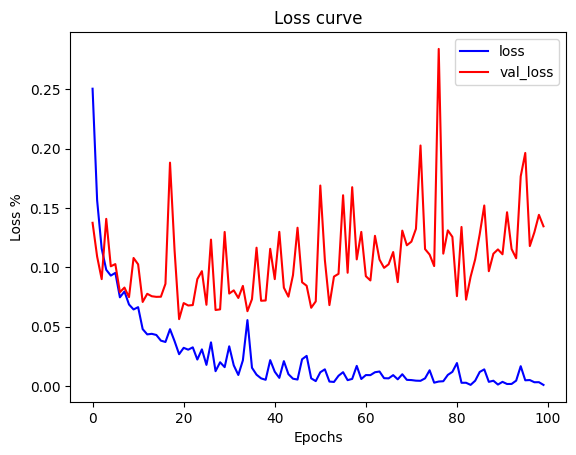

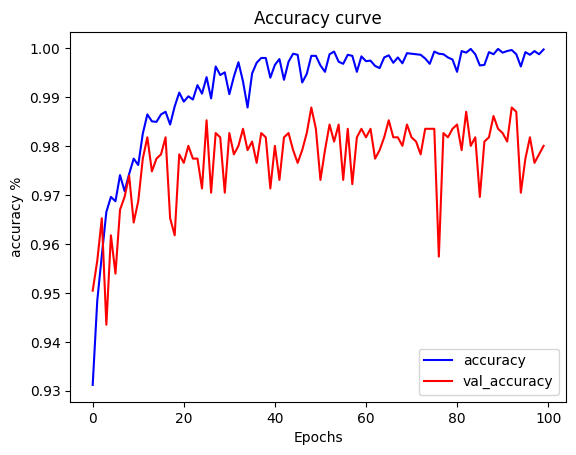





---- dense1 unit = 32 ---- dense2 unit = 32-------
Epoch 1/100
288/288 [==============================] - 5s 9ms/step - loss: 0.1670 - accuracy: 0.9407 - val_loss: 0.1711 - val_accuracy: 0.9391
Epoch 2/100
288/288 [==============================] - 2s 7ms/step - loss: 0.1166 - accuracy: 0.9548 - val_loss: 0.1375 - val_accuracy: 0.9252
Epoch 3/100
288/288 [==============================] - 2s 7ms/step - loss: 0.1124 - accuracy: 0.9576 - val_loss: 0.1128 - val_accuracy: 0.9530
Epoch 4/100
288/288 [==============================] - 2s 7ms/step - loss: 0.0997 - accuracy: 0.9620 - val_loss: 0.1005 - val_accuracy: 0.9635
Epoch 5/100
288/288 [==============================] - 2s 7ms/step - loss: 0.0862 - accuracy: 0.9658 - val_loss: 0.0841 - val_accuracy: 0.9609
Epoch 6/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0803 - accuracy: 0.9697 - val_loss: 0.0993 - val_accuracy: 0.9583
Epoch 7/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0898 - acc

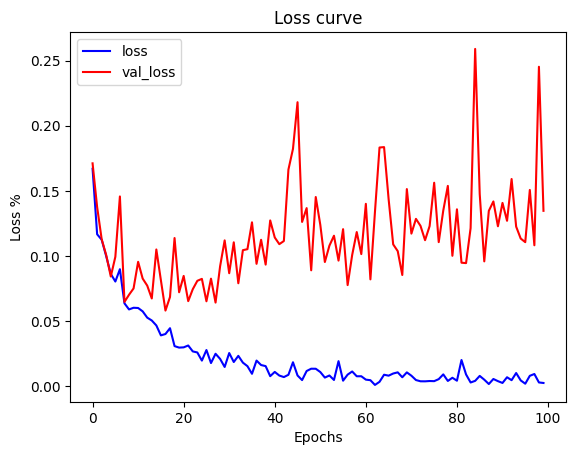

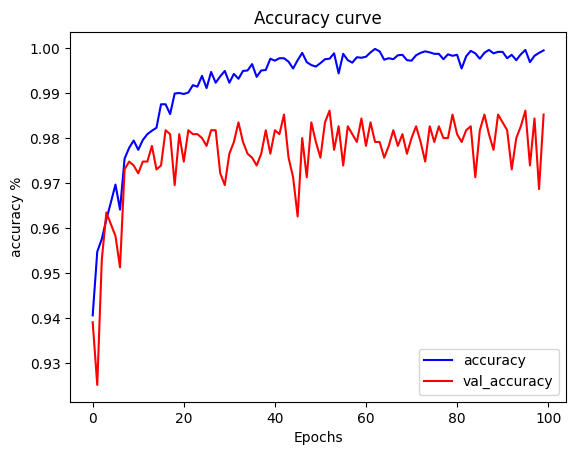





---- dense1 unit = 32 ---- dense2 unit = 64-------
Epoch 1/100
288/288 [==============================] - 6s 10ms/step - loss: 0.1712 - accuracy: 0.9380 - val_loss: 0.1329 - val_accuracy: 0.9530
Epoch 2/100
288/288 [==============================] - 2s 7ms/step - loss: 0.1217 - accuracy: 0.9515 - val_loss: 0.1158 - val_accuracy: 0.9626
Epoch 3/100
288/288 [==============================] - 2s 8ms/step - loss: 0.1228 - accuracy: 0.9543 - val_loss: 0.0955 - val_accuracy: 0.9643
Epoch 4/100
288/288 [==============================] - 2s 8ms/step - loss: 0.1028 - accuracy: 0.9620 - val_loss: 0.0856 - val_accuracy: 0.9730
Epoch 5/100
288/288 [==============================] - 2s 7ms/step - loss: 0.1015 - accuracy: 0.9627 - val_loss: 0.0863 - val_accuracy: 0.9670
Epoch 6/100
288/288 [==============================] - 2s 7ms/step - loss: 0.0884 - accuracy: 0.9666 - val_loss: 0.0952 - val_accuracy: 0.9696
Epoch 7/100
288/288 [==============================] - 2s 7ms/step - loss: 0.0854 - ac

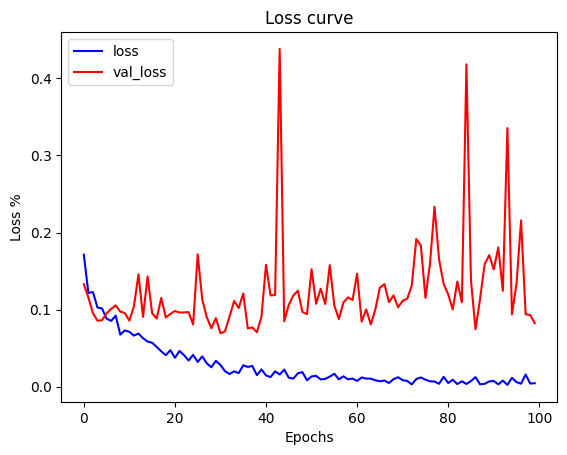

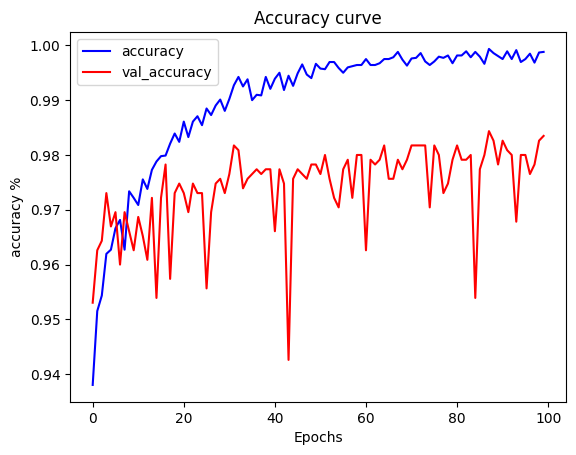





---- dense1 unit = 32 ---- dense2 unit = 128-------
Epoch 1/100
288/288 [==============================] - 5s 8ms/step - loss: 0.1648 - accuracy: 0.9395 - val_loss: 0.1301 - val_accuracy: 0.9574
Epoch 2/100
288/288 [==============================] - 2s 8ms/step - loss: 0.1270 - accuracy: 0.9527 - val_loss: 0.1115 - val_accuracy: 0.9661
Epoch 3/100
288/288 [==============================] - 2s 8ms/step - loss: 0.1178 - accuracy: 0.9558 - val_loss: 0.1401 - val_accuracy: 0.9322
Epoch 4/100
288/288 [==============================] - 2s 8ms/step - loss: 0.1069 - accuracy: 0.9583 - val_loss: 0.1211 - val_accuracy: 0.9522
Epoch 5/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0969 - accuracy: 0.9653 - val_loss: 0.0918 - val_accuracy: 0.9626
Epoch 6/100
288/288 [==============================] - 2s 7ms/step - loss: 0.0874 - accuracy: 0.9673 - val_loss: 0.1262 - val_accuracy: 0.9661
Epoch 7/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0988 - ac

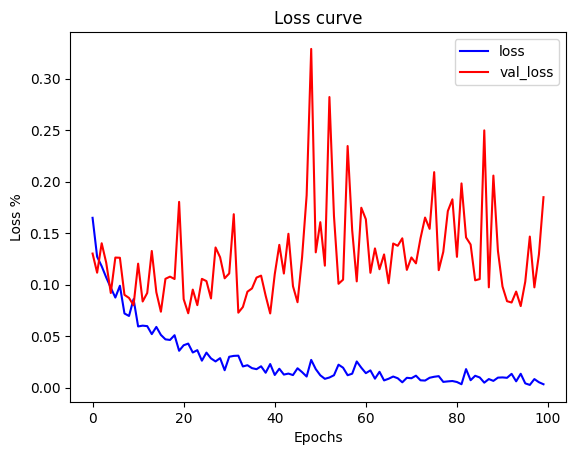

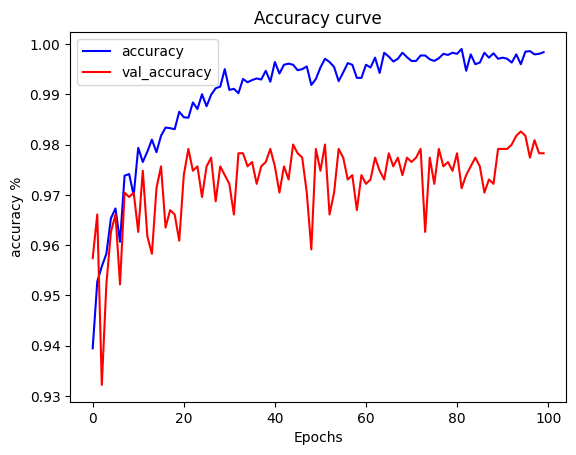





---- dense1 unit = 32 ---- dense2 unit = 256-------
Epoch 1/100
288/288 [==============================] - 6s 10ms/step - loss: 0.1634 - accuracy: 0.9414 - val_loss: 0.1078 - val_accuracy: 0.9426
Epoch 2/100
288/288 [==============================] - 2s 8ms/step - loss: 0.1180 - accuracy: 0.9558 - val_loss: 0.0950 - val_accuracy: 0.9652
Epoch 3/100
288/288 [==============================] - 2s 8ms/step - loss: 0.1159 - accuracy: 0.9554 - val_loss: 0.1235 - val_accuracy: 0.9609
Epoch 4/100
288/288 [==============================] - 2s 8ms/step - loss: 0.1065 - accuracy: 0.9609 - val_loss: 0.0914 - val_accuracy: 0.9643
Epoch 5/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0956 - accuracy: 0.9624 - val_loss: 0.1056 - val_accuracy: 0.9652
Epoch 6/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0902 - accuracy: 0.9649 - val_loss: 0.0895 - val_accuracy: 0.9696
Epoch 7/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0892 - a

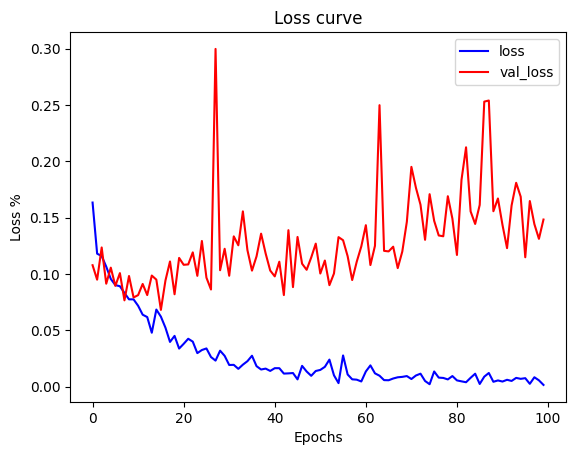

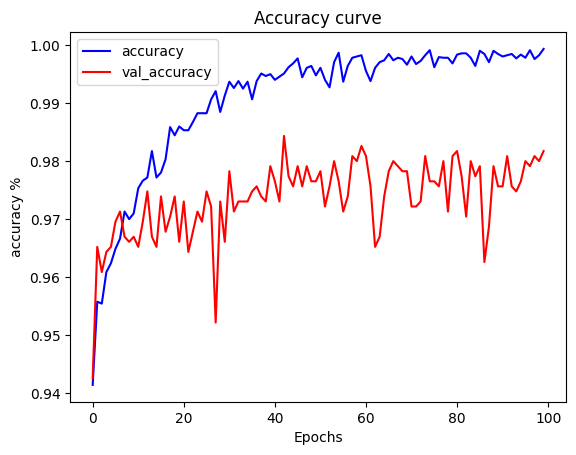





---- dense1 unit = 32 ---- dense2 unit = 512-------
Epoch 1/100
288/288 [==============================] - 6s 9ms/step - loss: 0.1737 - accuracy: 0.9393 - val_loss: 0.1494 - val_accuracy: 0.9539
Epoch 2/100
288/288 [==============================] - 2s 8ms/step - loss: 0.1320 - accuracy: 0.9497 - val_loss: 0.2095 - val_accuracy: 0.9296
Epoch 3/100
288/288 [==============================] - 2s 8ms/step - loss: 0.1369 - accuracy: 0.9470 - val_loss: 0.0966 - val_accuracy: 0.9635
Epoch 4/100
288/288 [==============================] - 2s 8ms/step - loss: 0.1143 - accuracy: 0.9558 - val_loss: 0.0996 - val_accuracy: 0.9652
Epoch 5/100
288/288 [==============================] - 2s 9ms/step - loss: 0.1056 - accuracy: 0.9597 - val_loss: 0.1338 - val_accuracy: 0.9635
Epoch 6/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0982 - accuracy: 0.9630 - val_loss: 0.0898 - val_accuracy: 0.9704
Epoch 7/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0929 - ac

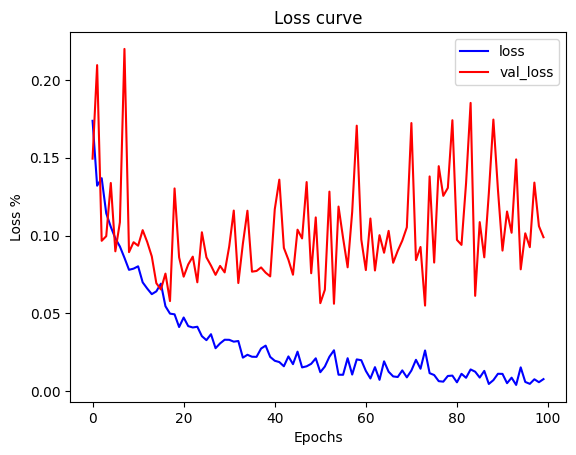

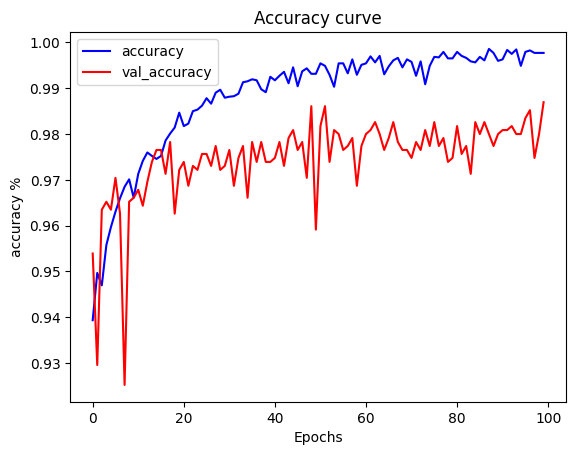





---- dense1 unit = 64 ---- dense2 unit = 16-------
Epoch 1/100
288/288 [==============================] - 6s 9ms/step - loss: 0.1716 - accuracy: 0.9366 - val_loss: 0.1277 - val_accuracy: 0.9591
Epoch 2/100
288/288 [==============================] - 2s 8ms/step - loss: 0.1297 - accuracy: 0.9509 - val_loss: 0.1067 - val_accuracy: 0.9504
Epoch 3/100
288/288 [==============================] - 2s 8ms/step - loss: 0.1080 - accuracy: 0.9583 - val_loss: 0.0900 - val_accuracy: 0.9565
Epoch 4/100
288/288 [==============================] - 3s 9ms/step - loss: 0.0945 - accuracy: 0.9668 - val_loss: 0.0786 - val_accuracy: 0.9722
Epoch 5/100
288/288 [==============================] - 3s 9ms/step - loss: 0.0840 - accuracy: 0.9686 - val_loss: 0.1434 - val_accuracy: 0.9522
Epoch 6/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0753 - accuracy: 0.9733 - val_loss: 0.0910 - val_accuracy: 0.9730
Epoch 7/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0690 - acc

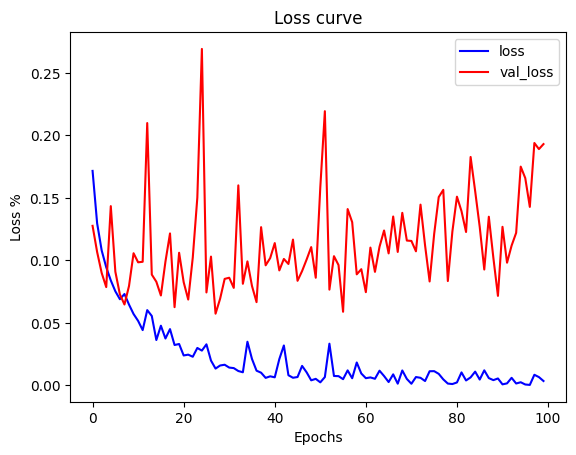

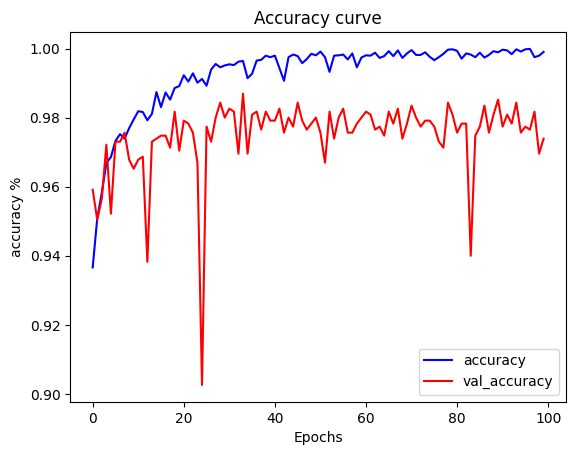





---- dense1 unit = 64 ---- dense2 unit = 32-------
Epoch 1/100
288/288 [==============================] - 5s 9ms/step - loss: 0.2065 - accuracy: 0.9336 - val_loss: 0.1194 - val_accuracy: 0.9574
Epoch 2/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1326 - accuracy: 0.9520 - val_loss: 0.0999 - val_accuracy: 0.9635
Epoch 3/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0998 - accuracy: 0.9629 - val_loss: 0.0944 - val_accuracy: 0.9687
Epoch 4/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0921 - accuracy: 0.9654 - val_loss: 0.1053 - val_accuracy: 0.9609
Epoch 5/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0935 - accuracy: 0.9675 - val_loss: 0.0936 - val_accuracy: 0.9678
Epoch 6/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0980 - accuracy: 0.9649 - val_loss: 0.1632 - val_accuracy: 0.9400
Epoch 7/100
288/288 [==============================] - 2s 9ms/step - loss: 0.0701 - acc

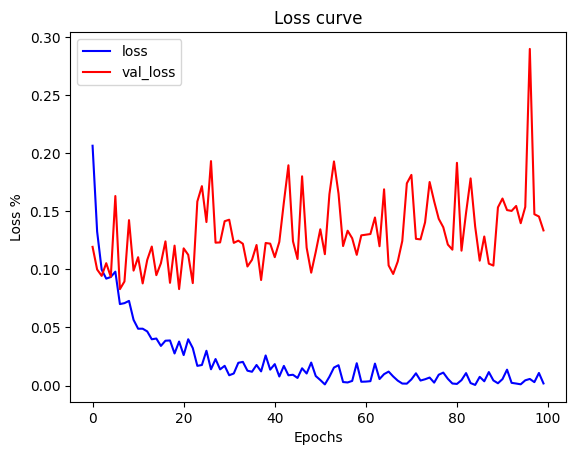

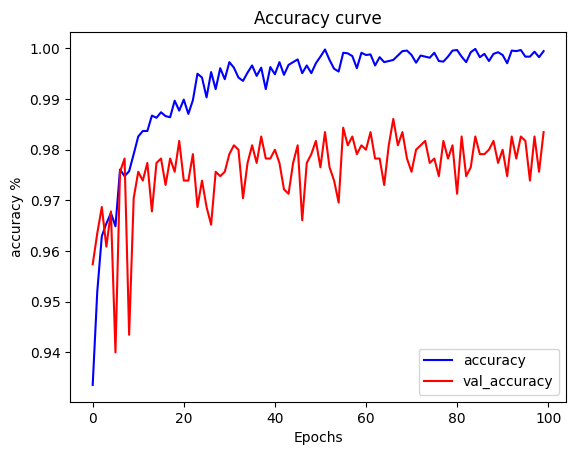





---- dense1 unit = 64 ---- dense2 unit = 64-------
Epoch 1/100
288/288 [==============================] - 6s 9ms/step - loss: 0.2071 - accuracy: 0.9337 - val_loss: 0.1364 - val_accuracy: 0.9513
Epoch 2/100
288/288 [==============================] - 2s 8ms/step - loss: 0.1163 - accuracy: 0.9574 - val_loss: 0.0976 - val_accuracy: 0.9652
Epoch 3/100
288/288 [==============================] - 2s 8ms/step - loss: 0.1071 - accuracy: 0.9627 - val_loss: 0.0881 - val_accuracy: 0.9687
Epoch 4/100
288/288 [==============================] - 2s 9ms/step - loss: 0.0901 - accuracy: 0.9680 - val_loss: 0.0968 - val_accuracy: 0.9626
Epoch 5/100
288/288 [==============================] - 3s 9ms/step - loss: 0.0847 - accuracy: 0.9691 - val_loss: 0.0866 - val_accuracy: 0.9748
Epoch 6/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0758 - accuracy: 0.9723 - val_loss: 0.0970 - val_accuracy: 0.9670
Epoch 7/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0811 - acc

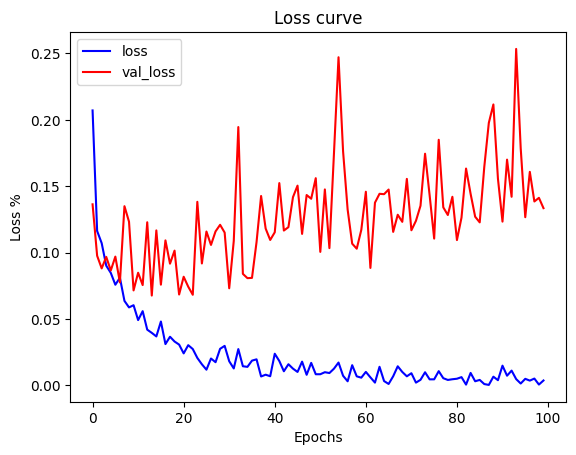

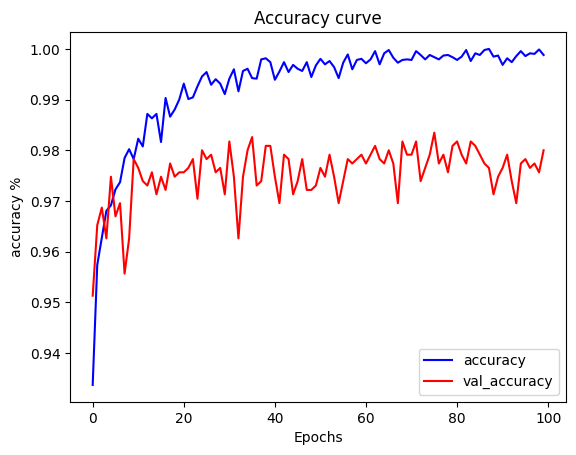





---- dense1 unit = 64 ---- dense2 unit = 128-------
Epoch 1/100
288/288 [==============================] - 7s 9ms/step - loss: 0.2180 - accuracy: 0.9353 - val_loss: 0.1105 - val_accuracy: 0.9670
Epoch 2/100
288/288 [==============================] - 2s 8ms/step - loss: 0.1121 - accuracy: 0.9584 - val_loss: 0.1113 - val_accuracy: 0.9557
Epoch 3/100
288/288 [==============================] - 2s 8ms/step - loss: 0.1090 - accuracy: 0.9560 - val_loss: 0.1173 - val_accuracy: 0.9643
Epoch 4/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1014 - accuracy: 0.9641 - val_loss: 0.0911 - val_accuracy: 0.9661
Epoch 5/100
288/288 [==============================] - 3s 9ms/step - loss: 0.0765 - accuracy: 0.9707 - val_loss: 0.1179 - val_accuracy: 0.9626
Epoch 6/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0615 - accuracy: 0.9766 - val_loss: 0.1115 - val_accuracy: 0.9635
Epoch 7/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0705 - ac

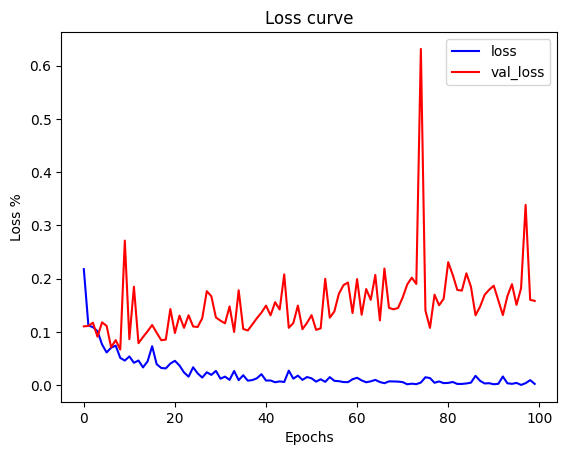

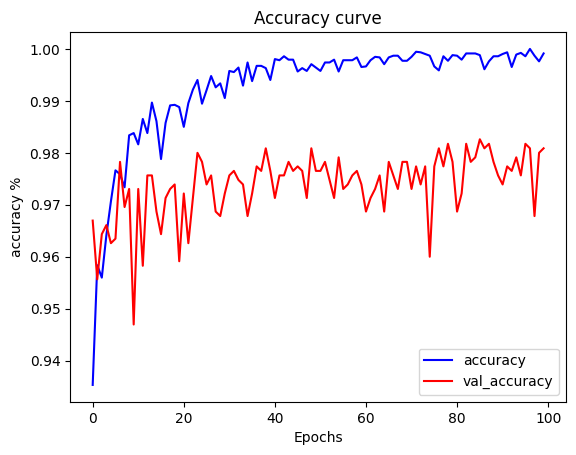





---- dense1 unit = 64 ---- dense2 unit = 256-------
Epoch 1/100
288/288 [==============================] - 6s 9ms/step - loss: 0.2054 - accuracy: 0.9304 - val_loss: 0.1088 - val_accuracy: 0.9557
Epoch 2/100
288/288 [==============================] - 2s 8ms/step - loss: 0.1186 - accuracy: 0.9546 - val_loss: 0.1076 - val_accuracy: 0.9652
Epoch 3/100
288/288 [==============================] - 2s 8ms/step - loss: 0.1243 - accuracy: 0.9509 - val_loss: 0.1314 - val_accuracy: 0.9504
Epoch 4/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1011 - accuracy: 0.9615 - val_loss: 0.1201 - val_accuracy: 0.9643
Epoch 5/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0936 - accuracy: 0.9687 - val_loss: 0.0848 - val_accuracy: 0.9670
Epoch 6/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0875 - accuracy: 0.9697 - val_loss: 0.1014 - val_accuracy: 0.9661
Epoch 7/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0748 - a

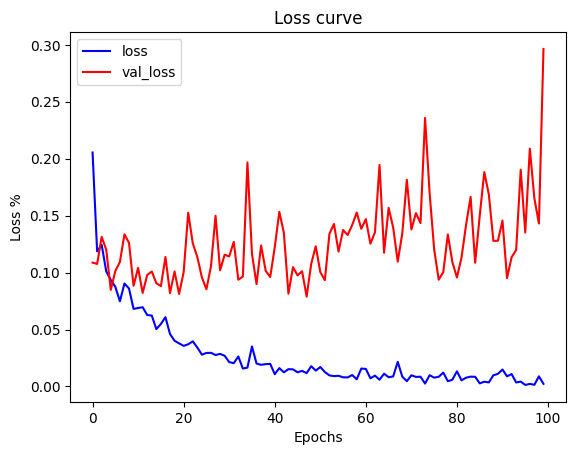

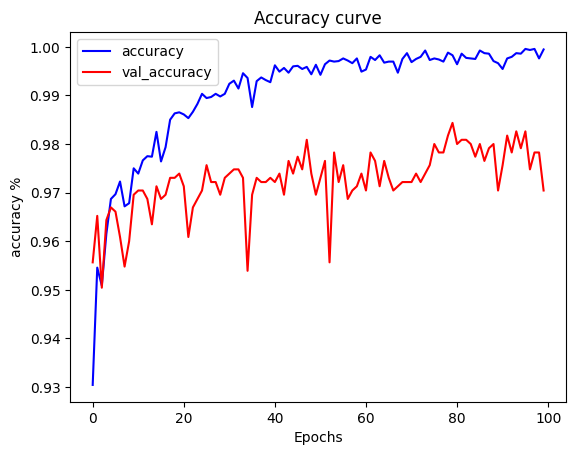





---- dense1 unit = 64 ---- dense2 unit = 512-------
Epoch 1/100
288/288 [==============================] - 6s 9ms/step - loss: 0.1805 - accuracy: 0.9347 - val_loss: 0.1058 - val_accuracy: 0.9504
Epoch 2/100
288/288 [==============================] - 2s 8ms/step - loss: 0.1300 - accuracy: 0.9486 - val_loss: 0.1413 - val_accuracy: 0.9652
Epoch 3/100
288/288 [==============================] - 2s 8ms/step - loss: 0.1233 - accuracy: 0.9548 - val_loss: 0.1275 - val_accuracy: 0.9461
Epoch 4/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1026 - accuracy: 0.9599 - val_loss: 0.0861 - val_accuracy: 0.9713
Epoch 5/100
288/288 [==============================] - 3s 9ms/step - loss: 0.0920 - accuracy: 0.9655 - val_loss: 0.0912 - val_accuracy: 0.9670
Epoch 6/100
288/288 [==============================] - 2s 8ms/step - loss: 0.1005 - accuracy: 0.9632 - val_loss: 0.1160 - val_accuracy: 0.9522
Epoch 7/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0836 - ac

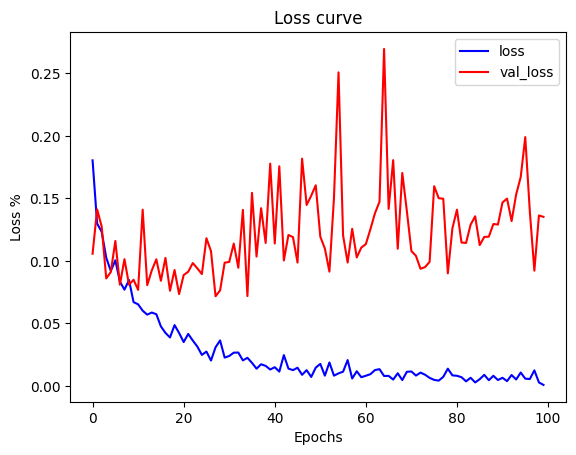

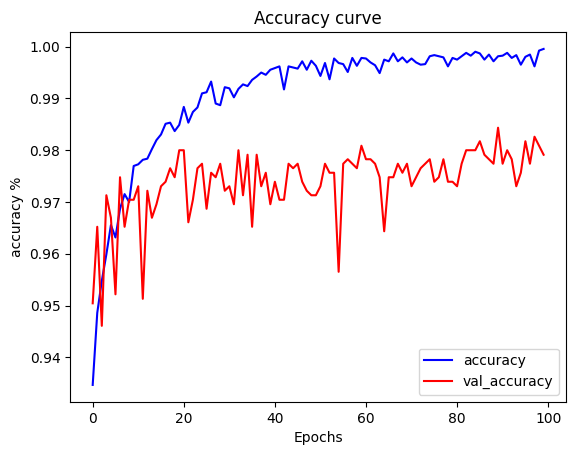





---- dense1 unit = 128 ---- dense2 unit = 16-------
Epoch 1/100
288/288 [==============================] - 7s 10ms/step - loss: 0.1659 - accuracy: 0.9409 - val_loss: 0.1099 - val_accuracy: 0.9452
Epoch 2/100
288/288 [==============================] - 2s 9ms/step - loss: 0.1297 - accuracy: 0.9472 - val_loss: 0.1191 - val_accuracy: 0.9322
Epoch 3/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1178 - accuracy: 0.9564 - val_loss: 0.0992 - val_accuracy: 0.9609
Epoch 4/100
288/288 [==============================] - 3s 9ms/step - loss: 0.0965 - accuracy: 0.9610 - val_loss: 0.1182 - val_accuracy: 0.9496
Epoch 5/100
288/288 [==============================] - 3s 9ms/step - loss: 0.0920 - accuracy: 0.9653 - val_loss: 0.0855 - val_accuracy: 0.9661
Epoch 6/100
288/288 [==============================] - 2s 9ms/step - loss: 0.0777 - accuracy: 0.9714 - val_loss: 0.0870 - val_accuracy: 0.9652
Epoch 7/100
288/288 [==============================] - 3s 9ms/step - loss: 0.0803 - a

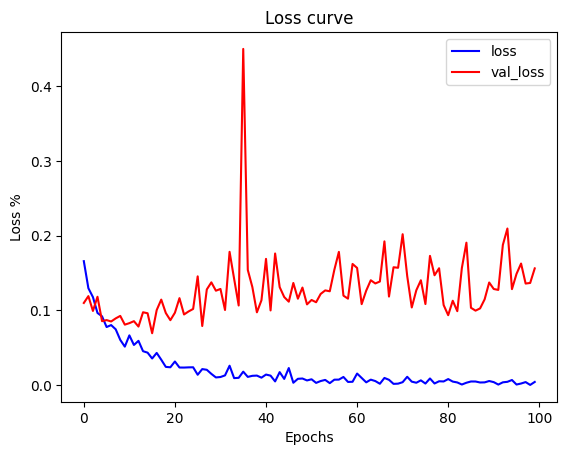

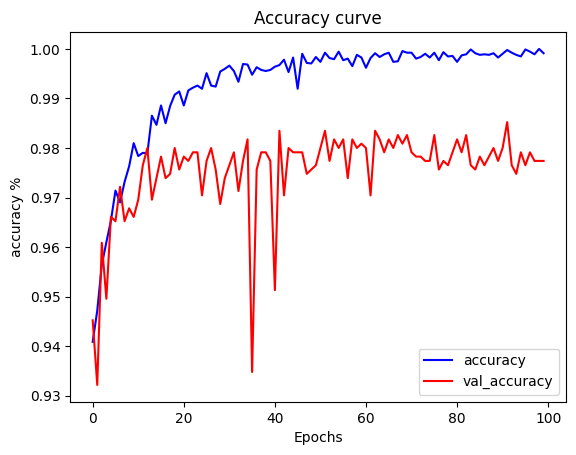





---- dense1 unit = 128 ---- dense2 unit = 32-------
Epoch 1/100
288/288 [==============================] - 7s 10ms/step - loss: 0.2674 - accuracy: 0.9309 - val_loss: 0.1387 - val_accuracy: 0.9565
Epoch 2/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1267 - accuracy: 0.9536 - val_loss: 0.1030 - val_accuracy: 0.9574
Epoch 3/100
288/288 [==============================] - 3s 9ms/step - loss: 0.0991 - accuracy: 0.9625 - val_loss: 0.0759 - val_accuracy: 0.9722
Epoch 4/100
288/288 [==============================] - 3s 9ms/step - loss: 0.0864 - accuracy: 0.9688 - val_loss: 0.0695 - val_accuracy: 0.9722
Epoch 5/100
288/288 [==============================] - 3s 11ms/step - loss: 0.0898 - accuracy: 0.9685 - val_loss: 0.0782 - val_accuracy: 0.9678
Epoch 6/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0687 - accuracy: 0.9766 - val_loss: 0.0747 - val_accuracy: 0.9757
Epoch 7/100
288/288 [==============================] - 2s 9ms/step - loss: 0.0542 -

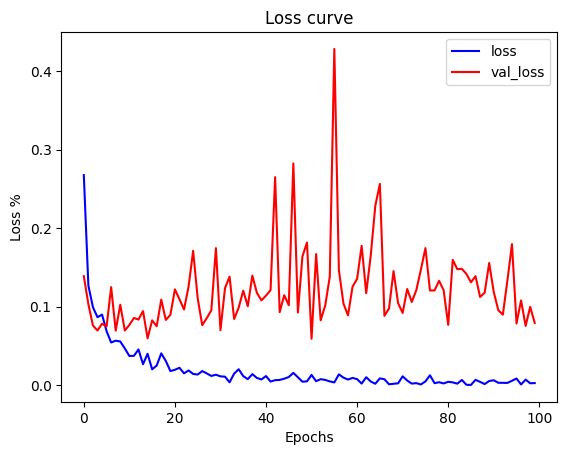

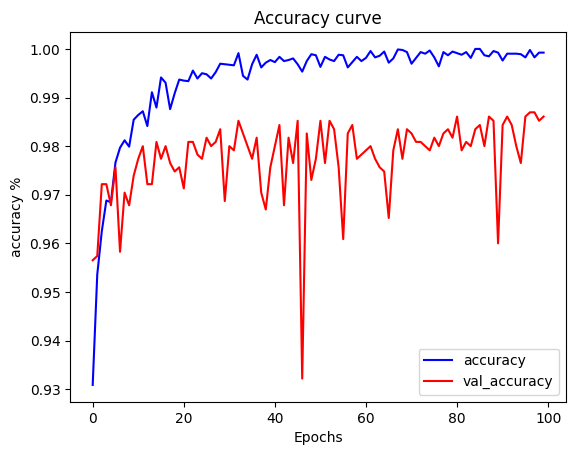





---- dense1 unit = 128 ---- dense2 unit = 64-------
Epoch 1/100
288/288 [==============================] - 6s 11ms/step - loss: 0.3095 - accuracy: 0.9253 - val_loss: 0.1023 - val_accuracy: 0.9600
Epoch 2/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1637 - accuracy: 0.9423 - val_loss: 0.1061 - val_accuracy: 0.9583
Epoch 3/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1309 - accuracy: 0.9527 - val_loss: 0.0916 - val_accuracy: 0.9678
Epoch 4/100
288/288 [==============================] - 3s 9ms/step - loss: 0.0894 - accuracy: 0.9649 - val_loss: 0.1098 - val_accuracy: 0.9670
Epoch 5/100
288/288 [==============================] - 3s 9ms/step - loss: 0.0834 - accuracy: 0.9693 - val_loss: 0.0747 - val_accuracy: 0.9791
Epoch 6/100
288/288 [==============================] - 3s 9ms/step - loss: 0.0693 - accuracy: 0.9763 - val_loss: 0.0733 - val_accuracy: 0.9757
Epoch 7/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0705 -

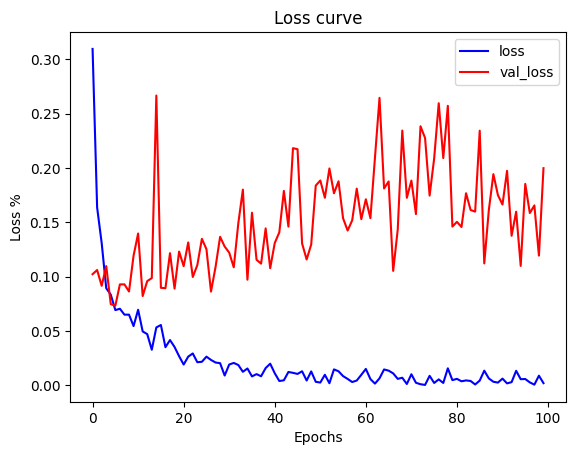

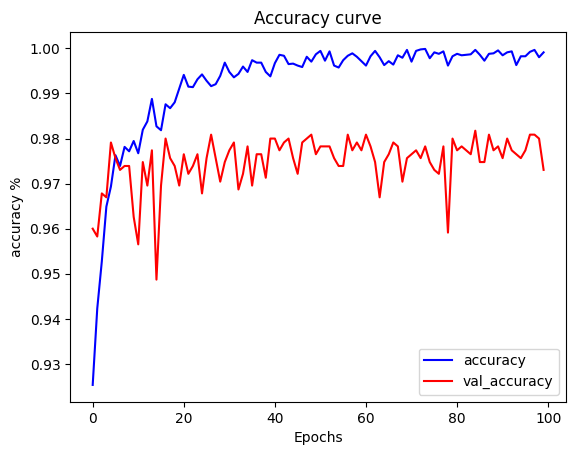





---- dense1 unit = 128 ---- dense2 unit = 128-------
Epoch 1/100
288/288 [==============================] - 6s 10ms/step - loss: 0.2366 - accuracy: 0.9360 - val_loss: 0.1183 - val_accuracy: 0.9513
Epoch 2/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1369 - accuracy: 0.9514 - val_loss: 0.1182 - val_accuracy: 0.9565
Epoch 3/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1089 - accuracy: 0.9600 - val_loss: 0.1002 - val_accuracy: 0.9591
Epoch 4/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0954 - accuracy: 0.9642 - val_loss: 0.0708 - val_accuracy: 0.9757
Epoch 5/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0736 - accuracy: 0.9737 - val_loss: 0.0882 - val_accuracy: 0.9713
Epoch 6/100
288/288 [==============================] - 3s 9ms/step - loss: 0.0742 - accuracy: 0.9737 - val_loss: 0.0969 - val_accuracy: 0.9687
Epoch 7/100
288/288 [==============================] - 3s 9ms/step - loss: 0.0643 

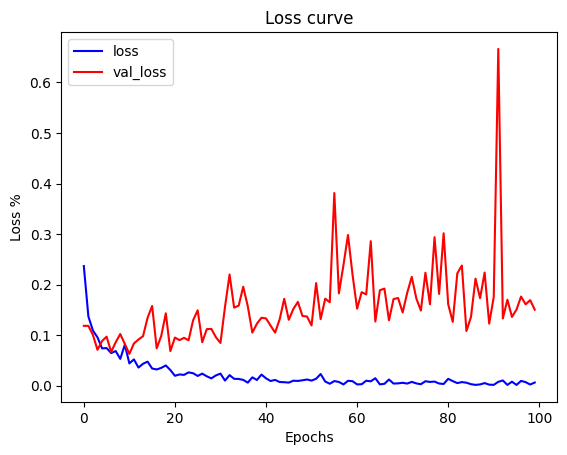

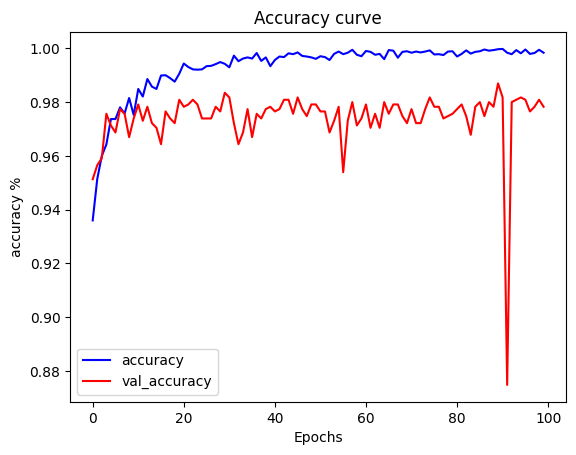





---- dense1 unit = 128 ---- dense2 unit = 256-------
Epoch 1/100
288/288 [==============================] - 6s 10ms/step - loss: 0.2375 - accuracy: 0.9330 - val_loss: 0.1397 - val_accuracy: 0.9391
Epoch 2/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1336 - accuracy: 0.9514 - val_loss: 0.1141 - val_accuracy: 0.9687
Epoch 3/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1046 - accuracy: 0.9613 - val_loss: 0.0943 - val_accuracy: 0.9696
Epoch 4/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1044 - accuracy: 0.9651 - val_loss: 0.0938 - val_accuracy: 0.9670
Epoch 5/100
288/288 [==============================] - 3s 9ms/step - loss: 0.0859 - accuracy: 0.9711 - val_loss: 0.1112 - val_accuracy: 0.9678
Epoch 6/100
288/288 [==============================] - 3s 9ms/step - loss: 0.0823 - accuracy: 0.9730 - val_loss: 0.1234 - val_accuracy: 0.9635
Epoch 7/100
288/288 [==============================] - 3s 11ms/step - loss: 0.0672 

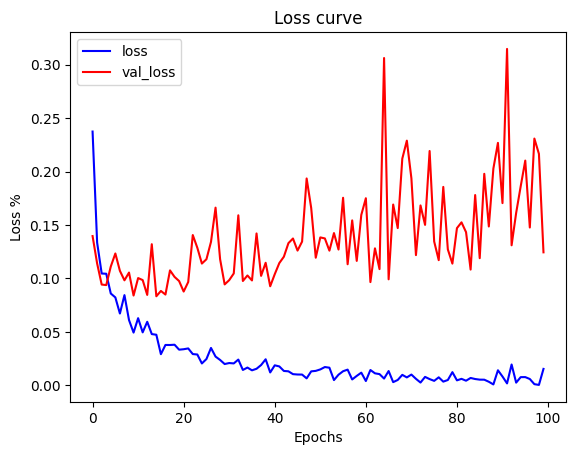

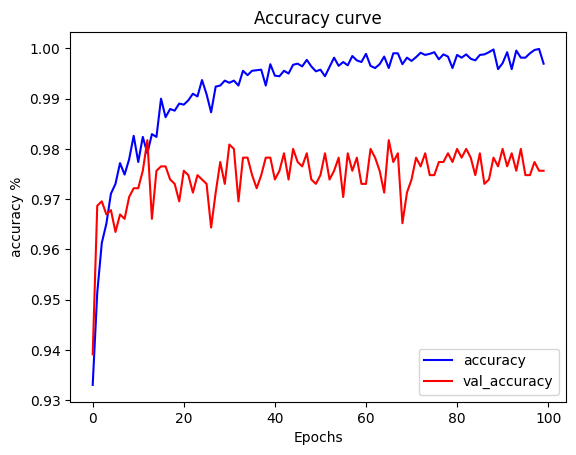





---- dense1 unit = 128 ---- dense2 unit = 512-------
Epoch 1/100
288/288 [==============================] - 6s 10ms/step - loss: 0.1968 - accuracy: 0.9386 - val_loss: 0.1192 - val_accuracy: 0.9565
Epoch 2/100
288/288 [==============================] - 3s 11ms/step - loss: 0.1293 - accuracy: 0.9536 - val_loss: 0.1107 - val_accuracy: 0.9591
Epoch 3/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1094 - accuracy: 0.9623 - val_loss: 0.0897 - val_accuracy: 0.9652
Epoch 4/100
288/288 [==============================] - 3s 9ms/step - loss: 0.0935 - accuracy: 0.9620 - val_loss: 0.1376 - val_accuracy: 0.9600
Epoch 5/100
288/288 [==============================] - 3s 9ms/step - loss: 0.0988 - accuracy: 0.9630 - val_loss: 0.2043 - val_accuracy: 0.9339
Epoch 6/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0802 - accuracy: 0.9699 - val_loss: 0.0848 - val_accuracy: 0.9730
Epoch 7/100
288/288 [==============================] - 3s 11ms/step - loss: 0.0704

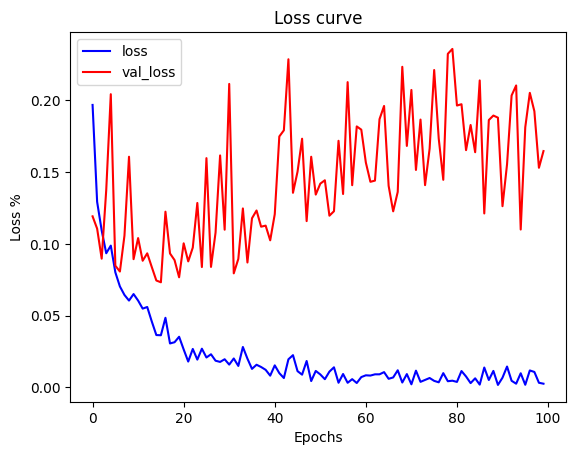

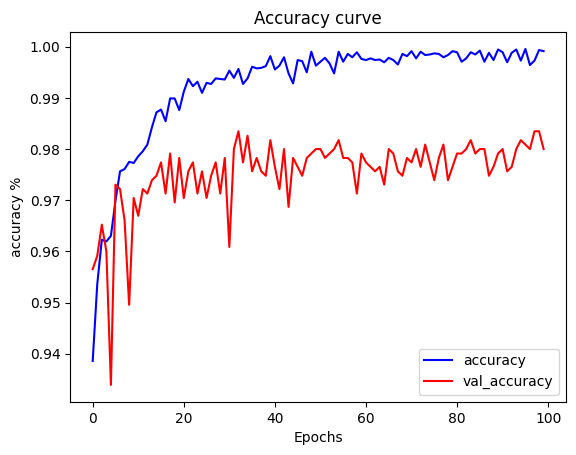





---- dense1 unit = 256 ---- dense2 unit = 16-------
Epoch 1/100
288/288 [==============================] - 6s 12ms/step - loss: 0.3452 - accuracy: 0.9132 - val_loss: 0.2000 - val_accuracy: 0.8000
Epoch 2/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1965 - accuracy: 0.9488 - val_loss: 0.1601 - val_accuracy: 0.9643
Epoch 3/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1813 - accuracy: 0.9430 - val_loss: 0.1543 - val_accuracy: 0.9522
Epoch 4/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1547 - accuracy: 0.9511 - val_loss: 0.1612 - val_accuracy: 0.9496
Epoch 5/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1259 - accuracy: 0.9646 - val_loss: 0.1067 - val_accuracy: 0.9678
Epoch 6/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1247 - accuracy: 0.9620 - val_loss: 0.1226 - val_accuracy: 0.9557
Epoch 7/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1154

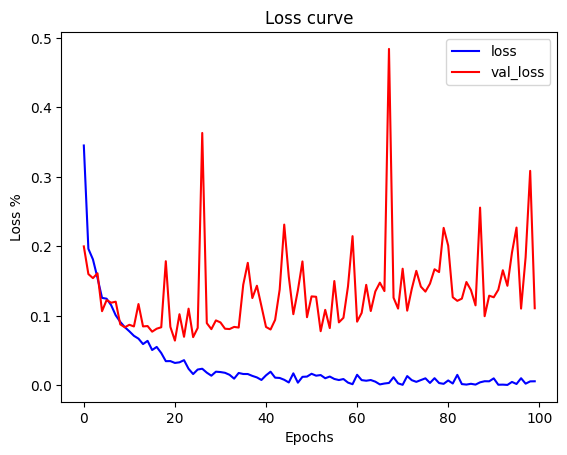

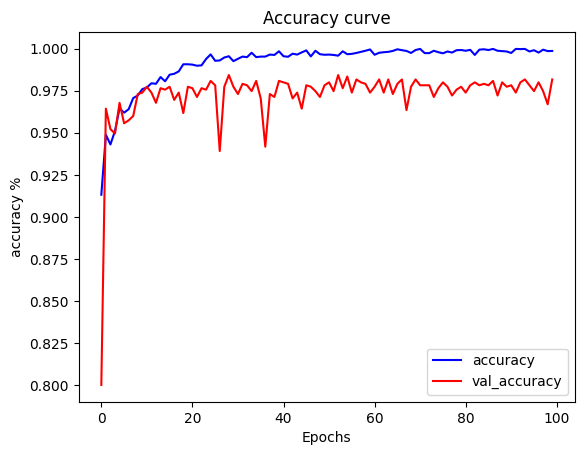





---- dense1 unit = 256 ---- dense2 unit = 32-------
Epoch 1/100
288/288 [==============================] - 6s 12ms/step - loss: 0.2043 - accuracy: 0.9357 - val_loss: 0.1422 - val_accuracy: 0.9609
Epoch 2/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1175 - accuracy: 0.9554 - val_loss: 0.1016 - val_accuracy: 0.9565
Epoch 3/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1062 - accuracy: 0.9596 - val_loss: 0.0927 - val_accuracy: 0.9617
Epoch 4/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0889 - accuracy: 0.9661 - val_loss: 0.0736 - val_accuracy: 0.9730
Epoch 5/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0770 - accuracy: 0.9725 - val_loss: 0.1429 - val_accuracy: 0.9496
Epoch 6/100
288/288 [==============================] - 3s 12ms/step - loss: 0.0678 - accuracy: 0.9730 - val_loss: 0.0863 - val_accuracy: 0.9661
Epoch 7/100
288/288 [==============================] - 3s 10ms/step - loss: 0.06

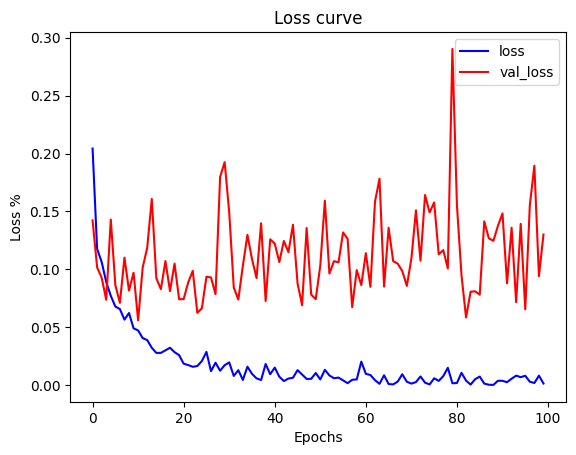

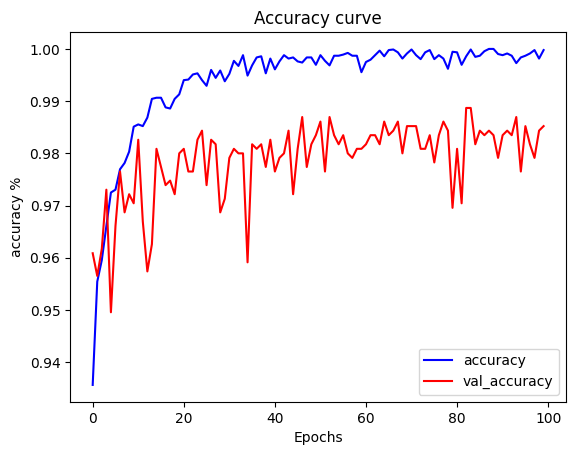





---- dense1 unit = 256 ---- dense2 unit = 64-------
Epoch 1/100
288/288 [==============================] - 6s 11ms/step - loss: 0.3955 - accuracy: 0.9288 - val_loss: 0.1304 - val_accuracy: 0.9513
Epoch 2/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1538 - accuracy: 0.9452 - val_loss: 0.0921 - val_accuracy: 0.9609
Epoch 3/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1268 - accuracy: 0.9543 - val_loss: 0.1504 - val_accuracy: 0.9470
Epoch 4/100
288/288 [==============================] - 3s 11ms/step - loss: 0.1129 - accuracy: 0.9601 - val_loss: 0.0842 - val_accuracy: 0.9687
Epoch 5/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0825 - accuracy: 0.9692 - val_loss: 0.0952 - val_accuracy: 0.9713
Epoch 6/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0625 - accuracy: 0.9782 - val_loss: 0.1069 - val_accuracy: 0.9652
Epoch 7/100
288/288 [==============================] - 3s 11ms/step - loss: 0.06

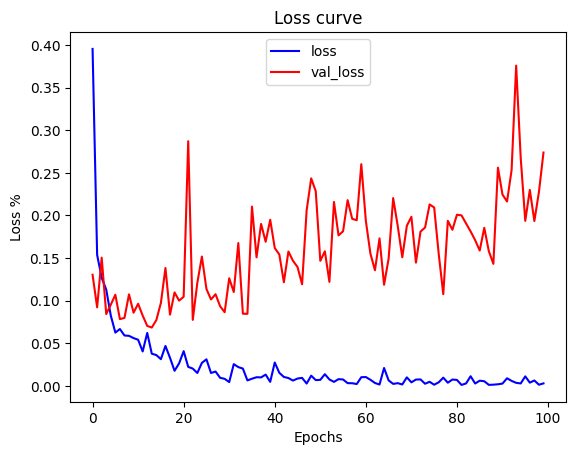

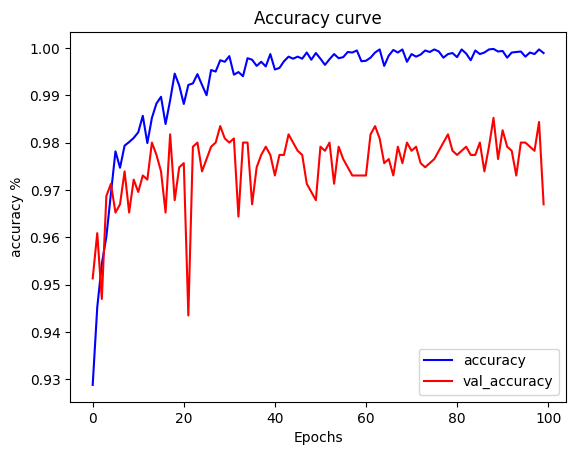





---- dense1 unit = 256 ---- dense2 unit = 128-------
Epoch 1/100
288/288 [==============================] - 6s 11ms/step - loss: 0.3895 - accuracy: 0.9313 - val_loss: 0.1405 - val_accuracy: 0.9452
Epoch 2/100
288/288 [==============================] - 3s 11ms/step - loss: 0.1596 - accuracy: 0.9461 - val_loss: 0.2070 - val_accuracy: 0.9226
Epoch 3/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1080 - accuracy: 0.9600 - val_loss: 0.0997 - val_accuracy: 0.9626
Epoch 4/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0984 - accuracy: 0.9667 - val_loss: 0.1328 - val_accuracy: 0.9513
Epoch 5/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0740 - accuracy: 0.9723 - val_loss: 0.0943 - val_accuracy: 0.9730
Epoch 6/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0823 - accuracy: 0.9735 - val_loss: 0.0941 - val_accuracy: 0.9678
Epoch 7/100
288/288 [==============================] - 3s 11ms/step - loss: 0.0

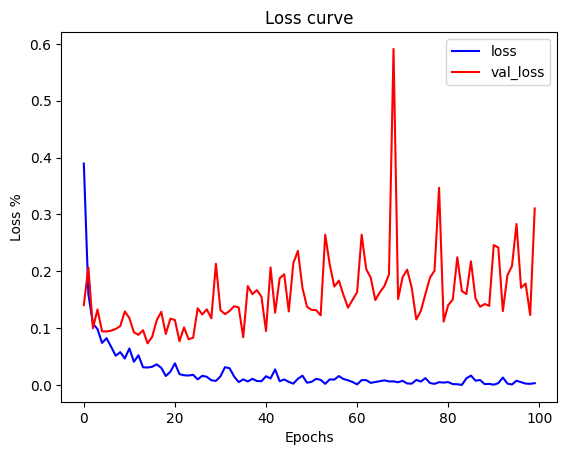

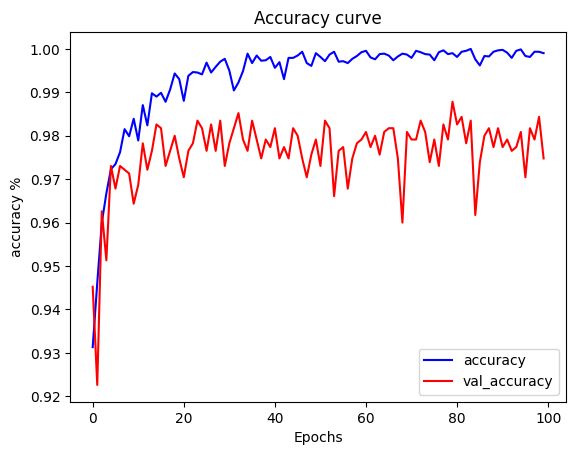





---- dense1 unit = 256 ---- dense2 unit = 256-------
Epoch 1/100
288/288 [==============================] - 6s 11ms/step - loss: 0.3150 - accuracy: 0.9340 - val_loss: 0.0930 - val_accuracy: 0.9652
Epoch 2/100
288/288 [==============================] - 3s 12ms/step - loss: 0.1217 - accuracy: 0.9572 - val_loss: 0.1494 - val_accuracy: 0.9478
Epoch 3/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1049 - accuracy: 0.9612 - val_loss: 0.0779 - val_accuracy: 0.9652
Epoch 4/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0900 - accuracy: 0.9686 - val_loss: 0.1063 - val_accuracy: 0.9600
Epoch 5/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0716 - accuracy: 0.9740 - val_loss: 0.0660 - val_accuracy: 0.9757
Epoch 6/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0772 - accuracy: 0.9726 - val_loss: 0.0862 - val_accuracy: 0.9643
Epoch 7/100
288/288 [==============================] - 3s 11ms/step - loss: 0.06

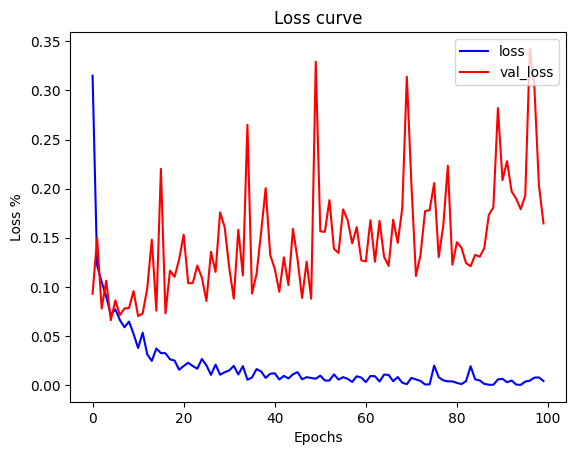

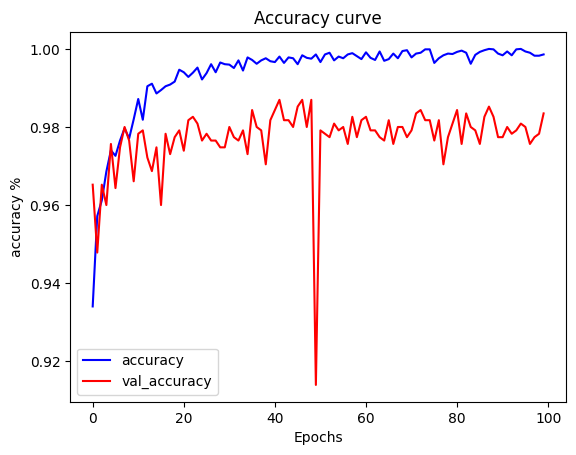





---- dense1 unit = 256 ---- dense2 unit = 512-------
Epoch 1/100
288/288 [==============================] - 6s 11ms/step - loss: 0.2869 - accuracy: 0.9353 - val_loss: 0.1056 - val_accuracy: 0.9504
Epoch 2/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1371 - accuracy: 0.9451 - val_loss: 0.1263 - val_accuracy: 0.9400
Epoch 3/100
288/288 [==============================] - 3s 11ms/step - loss: 0.1216 - accuracy: 0.9582 - val_loss: 0.1105 - val_accuracy: 0.9687
Epoch 4/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1053 - accuracy: 0.9627 - val_loss: 0.1019 - val_accuracy: 0.9661
Epoch 5/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1171 - accuracy: 0.9602 - val_loss: 0.1103 - val_accuracy: 0.9583
Epoch 6/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0900 - accuracy: 0.9687 - val_loss: 0.1127 - val_accuracy: 0.9687
Epoch 7/100
288/288 [==============================] - 3s 11ms/step - loss: 0.08

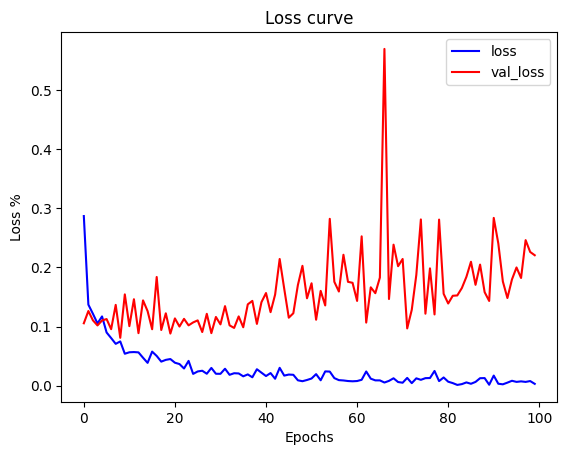

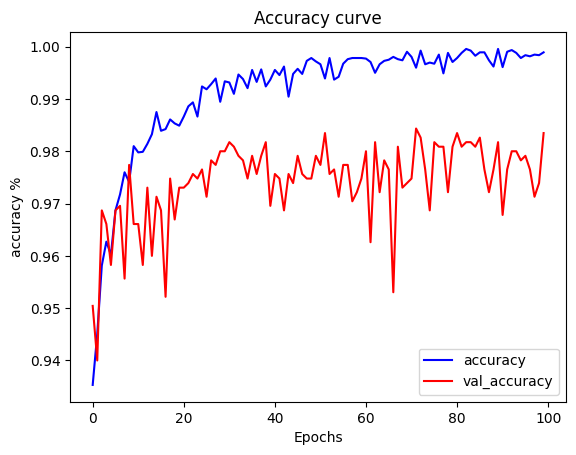





---- dense1 unit = 512 ---- dense2 unit = 16-------
Epoch 1/100
288/288 [==============================] - 8s 16ms/step - loss: 0.3750 - accuracy: 0.9389 - val_loss: 0.1167 - val_accuracy: 0.9591
Epoch 2/100
288/288 [==============================] - 3s 11ms/step - loss: 0.1286 - accuracy: 0.9527 - val_loss: 0.1075 - val_accuracy: 0.9574
Epoch 3/100
288/288 [==============================] - 3s 11ms/step - loss: 0.1072 - accuracy: 0.9599 - val_loss: 0.1384 - val_accuracy: 0.9478
Epoch 4/100
288/288 [==============================] - 3s 11ms/step - loss: 0.0963 - accuracy: 0.9649 - val_loss: 0.0714 - val_accuracy: 0.9748
Epoch 5/100
288/288 [==============================] - 3s 11ms/step - loss: 0.0889 - accuracy: 0.9686 - val_loss: 0.0851 - val_accuracy: 0.9670
Epoch 6/100
288/288 [==============================] - 3s 12ms/step - loss: 0.0943 - accuracy: 0.9661 - val_loss: 0.0781 - val_accuracy: 0.9757
Epoch 7/100
288/288 [==============================] - 3s 11ms/step - loss: 0.07

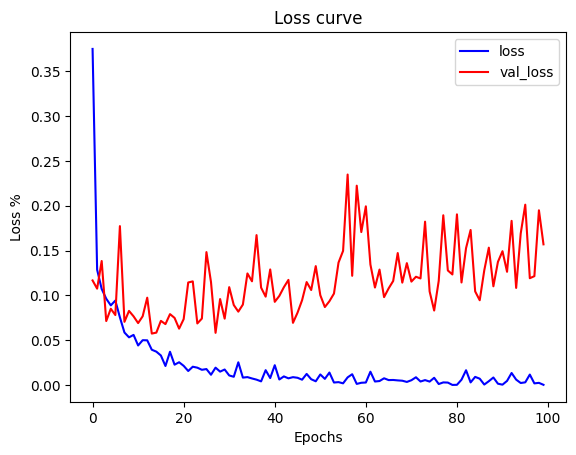

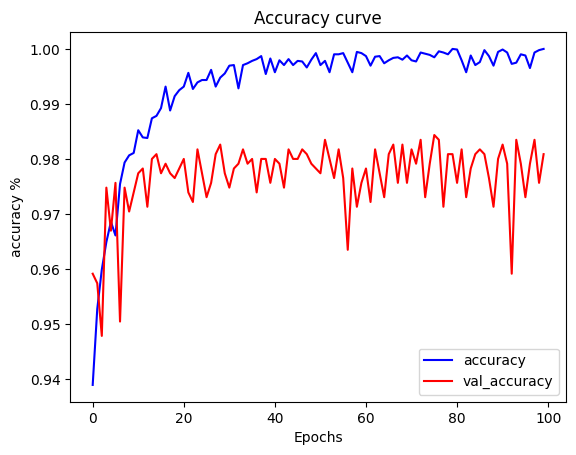





---- dense1 unit = 512 ---- dense2 unit = 32-------
Epoch 1/100
288/288 [==============================] - 7s 12ms/step - loss: 0.4767 - accuracy: 0.9297 - val_loss: 0.2279 - val_accuracy: 0.9261
Epoch 2/100
288/288 [==============================] - 3s 11ms/step - loss: 0.1606 - accuracy: 0.9432 - val_loss: 0.1209 - val_accuracy: 0.9443
Epoch 3/100
288/288 [==============================] - 3s 11ms/step - loss: 0.1172 - accuracy: 0.9515 - val_loss: 0.0896 - val_accuracy: 0.9670
Epoch 4/100
288/288 [==============================] - 3s 12ms/step - loss: 0.1311 - accuracy: 0.9521 - val_loss: 0.0807 - val_accuracy: 0.9704
Epoch 5/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0917 - accuracy: 0.9650 - val_loss: 0.0749 - val_accuracy: 0.9687
Epoch 6/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0746 - accuracy: 0.9728 - val_loss: 0.0689 - val_accuracy: 0.9730
Epoch 7/100
288/288 [==============================] - 3s 11ms/step - loss: 0.07

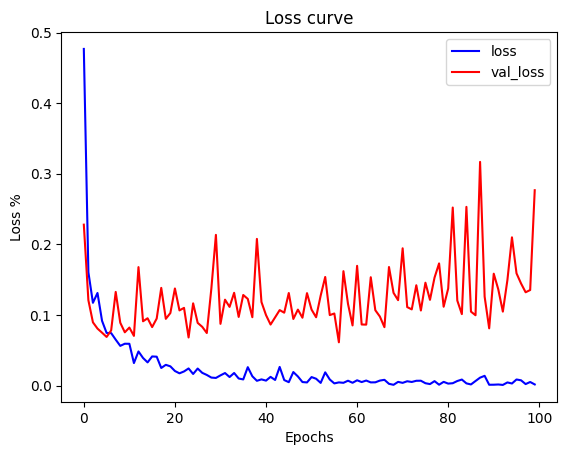

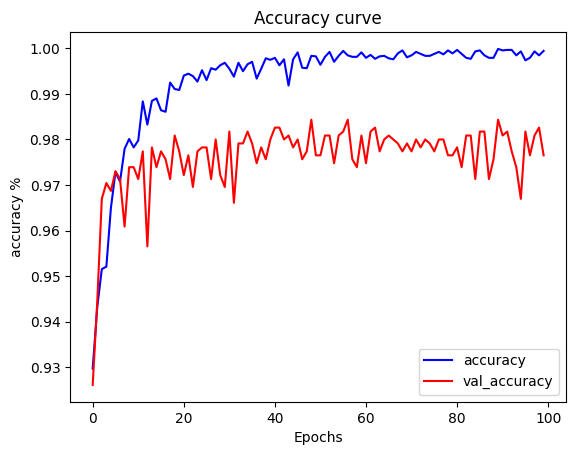





---- dense1 unit = 512 ---- dense2 unit = 64-------
Epoch 1/100
288/288 [==============================] - 7s 12ms/step - loss: 0.7313 - accuracy: 0.9334 - val_loss: 0.1185 - val_accuracy: 0.9626
Epoch 2/100
288/288 [==============================] - 3s 11ms/step - loss: 0.1352 - accuracy: 0.9535 - val_loss: 0.0867 - val_accuracy: 0.9704
Epoch 3/100
288/288 [==============================] - 3s 12ms/step - loss: 0.1048 - accuracy: 0.9645 - val_loss: 0.0978 - val_accuracy: 0.9670
Epoch 4/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1063 - accuracy: 0.9652 - val_loss: 0.1021 - val_accuracy: 0.9652
Epoch 5/100
288/288 [==============================] - 3s 11ms/step - loss: 0.0821 - accuracy: 0.9718 - val_loss: 0.1189 - val_accuracy: 0.9591
Epoch 6/100
288/288 [==============================] - 3s 11ms/step - loss: 0.0876 - accuracy: 0.9707 - val_loss: 0.0943 - val_accuracy: 0.9626
Epoch 7/100
288/288 [==============================] - 4s 13ms/step - loss: 0.06

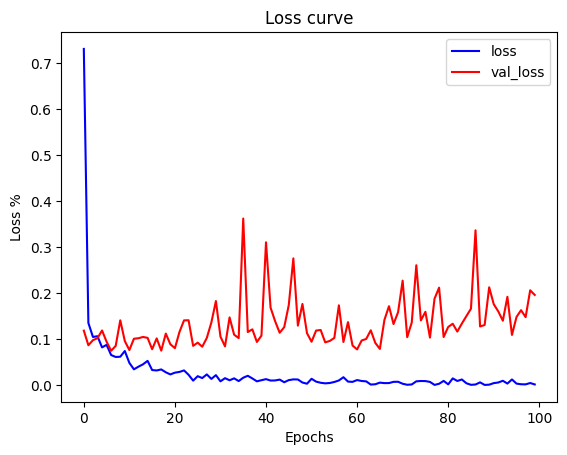

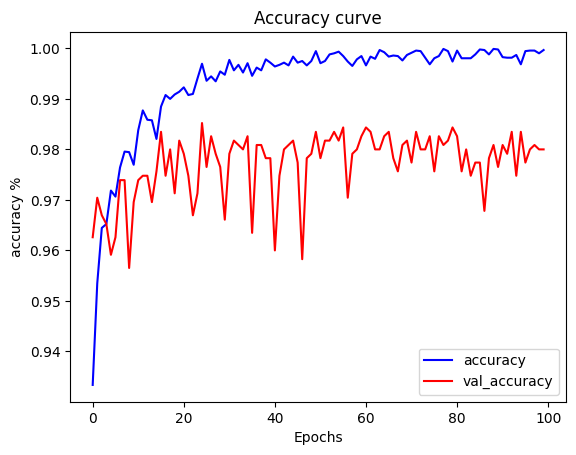





---- dense1 unit = 512 ---- dense2 unit = 128-------
Epoch 1/100
288/288 [==============================] - 7s 13ms/step - loss: 0.3438 - accuracy: 0.9328 - val_loss: 0.1210 - val_accuracy: 0.9539
Epoch 2/100
288/288 [==============================] - 3s 11ms/step - loss: 0.1261 - accuracy: 0.9543 - val_loss: 0.0903 - val_accuracy: 0.9643
Epoch 3/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1040 - accuracy: 0.9618 - val_loss: 0.0902 - val_accuracy: 0.9609
Epoch 4/100
288/288 [==============================] - 3s 11ms/step - loss: 0.0858 - accuracy: 0.9679 - val_loss: 0.0921 - val_accuracy: 0.9643
Epoch 5/100
288/288 [==============================] - 3s 11ms/step - loss: 0.0739 - accuracy: 0.9753 - val_loss: 0.0753 - val_accuracy: 0.9713
Epoch 6/100
288/288 [==============================] - 4s 13ms/step - loss: 0.0640 - accuracy: 0.9752 - val_loss: 0.0958 - val_accuracy: 0.9670
Epoch 7/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0

In [ ]:
dense1 = [32, 64, 128, 256, 512, 1024]

dense2 = [16, 32, 64, 128, 256, 512]


all_dense_history = []
all_dense_models = []

for d1_units in dense1:
    for d2_units in dense2:
        model = eegClassifier(input_shape, d1_units, d2_units)
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        print('\n\n\n')
        print(f'---- dense1 unit = {d1_units} ---- dense2 unit = {d2_units}-------')
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)
        all_dense_models.append(model)
        print('\n\n')
        print(model.summary())
        print('\n')
        plot_loss(history)
        plot_accuracy(history) 

        all_dense_history.append(history)
